# Compute correlations with metadata
## Setup
### Import packages

In [1]:
import warnings
from collections import defaultdict

import gurobipy as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rbc_gem_utils import (COBRA_CONFIGURATION, CURATION_PATH, PROCESSED_PATH,
                           ROOT_PATH, build_string, read_cobra_model,
                           show_versions)
from rbc_gem_utils.analysis.overlay import (DEFAULT_ENZYME_TOTAL_SUFFIX,
                                            ComplexDilution,
                                            load_overlay_model)
from rbc_gem_utils.visualization import cmap_map
from scipy.cluster.hierarchy import linkage
from scipy.stats import spearmanr

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Arial"

Set parameter Username

Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Informat

### Define configuration
#### COBRA Configuration

In [2]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,15
cache_directory,Path for the model cache,/Users/zhaiman/Library/Caches/cobrapy
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


## Load RBC-GEM model

In [3]:
model_id = "RBC_GEM"

data_path = (ROOT_PATH / "data" / "analysis" / "OVERLAY").resolve()
results_path = ROOT_PATH / PROCESSED_PATH / model_id / "OVERLAY"
results_path.mkdir(exist_ok=True, parents=True)

imagetype = "svg"
transparent = True
save_figures = True

dataset_name = "RBComics"
pcmodel_dirpath = data_path / model_id
dataset_path = results_path / dataset_name
dataset_models_dirpath = dataset_path / "pcmodels"

sample_prefix, time_prefix = ("S", "D")
# Integers are easier to work with for time points
timepoints = [10, 23, 42]

model = read_cobra_model(filename=pcmodel_dirpath / f"{model_id}.xml")
pcmodel = load_overlay_model(filename=pcmodel_dirpath / f"{model_id}_PC.xml")

# For this workflow, shut off complex dilution reactions at the start
for cplx_dilution in pcmodel.reactions.query(lambda x: isinstance(x, ComplexDilution)):
    cplx_dilution.bounds = (0, 0)

pcmodel

Name,RBC_GEM_PC
Memory address,14996a310
Number of metabolites,10410
Number of reactions,18799
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


## Load pcFVA generated results

In [4]:
pcfva_results_dirpath = dataset_path / "pcFVA"
corr_results_dirpath = dataset_path / "correlations"

In [5]:
# Test to see if results were recently generated in this run, otherwise load DataFrame of generated results
try:
    assert not df_pcfva_all.empty
except (NameError, AssertionError):
    df_pcfva_all = pd.read_csv(
        pcfva_results_dirpath / f"{pcmodel.id}_FVAresults_ALL.tsv",
        sep="\t",
        index_col=None,
    )

df_pcfva_all

,reactions,optimum,model,minimum,maximum
0,13DAMPPOX,0.00,RBC_GEM_PC_Mean_D10,0.000000,0.108130
1,13DAMPPOX,0.00,RBC_GEM_PC_Mean_D23,0.000000,0.108141
2,13DAMPPOX,0.00,RBC_GEM_PC_Mean_D42,0.000000,0.108129
3,13DAMPPOX,0.00,RBC_GEM_PC_Median_D10,0.000000,0.108220
4,13DAMPPOX,0.00,RBC_GEM_PC_Median_D23,0.000000,0.108230
...,...,...,...,...,...
145538995,ZN2t,0.99,RBC_GEM_PC_S99_D23,-0.741626,0.741626
145538996,ZN2t,0.99,RBC_GEM_PC_S99_D42,-0.742404,0.742404
145538997,ZN2t,0.99,RBC_GEM_PC_S9_D10,-0.744011,0.744011
145538998,ZN2t,0.99,RBC_GEM_PC_S9_D23,-0.742300,0.742300


In [6]:
def get_sample_from_id(model_id, sample_prefix=""):
    sample = model_id.rsplit("_", 2)[-2]
    try:
        return int(sample.replace(sample_prefix, ""))
    except ValueError:
        return sample


def get_time_from_id(model_id, time_prefix=""):
    time = model_id.rsplit("_", 2)[-1]
    try:
        return int(time.replace(time_prefix, ""))
    except ValueError:
        return time

In [7]:
list_of_pcmodels = list(df_pcfva_all["model"].unique())
operation_model_ids = sorted(
    [
        x
        for x in list_of_pcmodels
        if not isinstance(get_sample_from_id(x, sample_prefix), (int, float))
    ],
    key=lambda x: (
        get_sample_from_id(x, sample_prefix),
        get_time_from_id(x, time_prefix),
    ),
)
operations = set([get_sample_from_id(x, sample_prefix) for x in operation_model_ids])
operations

{'Mean', 'Median'}

In [8]:
enzyme_total_suffix = DEFAULT_ENZYME_TOTAL_SUFFIX
min_reaction_list = model.reactions.query(lambda x: x.gene_reaction_rule).list_attr(
    "id"
)
enzymes_list = pcmodel.reactions.query(
    lambda x: x.id.startswith(f"ENZDL_enzyme_") and f"{enzyme_total_suffix}" in x.id
).list_attr("id")
reaction_enzymes_map = {
    rid: tuple(
        pcmodel.reactions.query(
            lambda x: x.id.startswith(f"ENZDL_enzyme_{rid}_")
        ).list_attr("id")
    )
    for rid in min_reaction_list
}
enzyme_reaction_map = {
    enzyme: rid for rid, enzymes in reaction_enzymes_map.items() for enzyme in enzymes
}
if not enzymes_list:
    enzymes_list = [
        enzyme
        for enzyme, rid in enzyme_reaction_map.items()
        if rid in min_reaction_list
    ]
min_reaction_list += enzymes_list
print(
    f"Number of reactions minimize/maximize (minimum): {len(min_reaction_list)} / {len(pcmodel.reactions)}"
)

Number of reactions minimize/maximize (minimum): 4371 / 18799


### Parse main results into smaller DataFrames
#### Seperate by reaction variable types

In [9]:
# Initialize entries with prefixes used for seperating DataFrames
dict_of_dataframes_types = {
    "reactions": None,
    "proteins": "PROTDL",
    # "complexes": "CPLXFM",
    # "complex_dilutions": "CPLXDL",
    "enzymes": "ENZDL",
    # "enzyme_formation": "ENZFM",
    "budgets": "PBDL",
    "relaxation": "RELAX",
}
for key, prefix in dict_of_dataframes_types.copy().items():
    if prefix:
        df = df_pcfva_all[
            df_pcfva_all["reactions"].apply(lambda x: x.startswith(prefix))
        ]
    else:
        df = df_pcfva_all[
            df_pcfva_all["reactions"].apply(lambda x: x in model.reactions)
        ]
    dict_of_dataframes_types[key] = df.copy()

dict_of_dataframes_types;

#### Seperate by optimum value

In [10]:
# dict_of_dataframes_opt = {
#     optimum: df_pcfva_all[df_pcfva_all["optimum"] == optimum].copy()
#     for optimum in df_pcfva_all["optimum"].unique()
# }
# print(list(dict_of_dataframes_opt))

#### Seperate by model

In [11]:
# dict_of_dataframes_model = {
#     model_id: df_pcfva_all[df_pcfva_all["model"] == model_id].copy()
#     for model_id in df_pcfva_all["model"].unique()
# }
# print(list(dict_of_dataframes_model))

### Create DataFrame for correlation calculations
#### Get maximum reaction fluxes and associated abundance values

In [12]:
groupby_list = ["model", "reactions"]
always_abundance_independent = [
    r.id for r in model.reactions.query(lambda x: not x.boundary and not x.genes)
]
print(
    f"Number of reactions w/o genes, always abundance independent: {len(always_abundance_independent)}"
)
always_abundance_independent;

Number of reactions w/o genes, always abundance independent: 535


##### Get maximum reaction flux

In [13]:
# Get the maximum value of the reaction flux in each direction, regardless of percent optimum
df = dict_of_dataframes_types["reactions"].copy()
df = df.groupby(groupby_list)[["minimum", "maximum"]].agg(
    {
        "minimum": "min",
        "maximum": "max",
    }
)
df_max_flux_per_model = df.abs().max(axis=1)
df_max_flux_per_model.name = "Flux"
df_max_flux_per_model

model                reactions      
RBC_GEM_PC_Mean_D10  13DAMPPOX          0.108130
                     15KPGE1Ry          0.000000
                     15KPGE2Ry          0.000000
                     15KPGE3Ry          0.000000
                     15KPGF1Ry          0.000000
                                          ...   
RBC_GEM_PC_S9_D42    YYYTPAP            0.000000
                     ZN2Htex2           1.890257
                     ZN2_2HCO3t         2.277031
                     ZN2_HCO3_SELNIt    2.277031
                     ZN2t               0.743016
Name: Flux, Length: 6071850, dtype: float64

##### Get maximum flux range

In [14]:
# Determine flux range
df = dict_of_dataframes_types["reactions"].copy()
df["Range"] = df["maximum"] - df["minimum"]
df_flux_range_per_model = df.groupby(groupby_list)["Range"].max()
df_flux_range_per_model

model                reactions      
RBC_GEM_PC_Mean_D10  13DAMPPOX          0.108130
                     15KPGE1Ry          0.000000
                     15KPGE2Ry          0.000000
                     15KPGE3Ry          0.000000
                     15KPGF1Ry          0.000000
                                          ...   
RBC_GEM_PC_S9_D42    YYYTPAP            0.000000
                     ZN2Htex2           1.890257
                     ZN2_2HCO3t         2.277031
                     ZN2_HCO3_SELNIt    2.277031
                     ZN2t               1.486032
Name: Range, Length: 6071850, dtype: float64

##### Get maximum abundance

In [15]:
# Determine abundance association with reaction
df = dict_of_dataframes_types["enzymes"].copy()
df["reactions"] = df["reactions"].apply(lambda x: enzyme_reaction_map[x])
df_max_enzyme_per_model = df.groupby(groupby_list)["maximum"].max()
df_max_enzyme_per_model.name = "Abundance"
df_max_enzyme_per_model

model                reactions      
RBC_GEM_PC_Mean_D10  15KPGE1Ry          17.123347
                     15KPGE2Ry          17.123347
                     15KPGE3Ry          17.123347
                     15KPGF1Ry          17.123347
                     15KPGF2Ry          17.123347
                                          ...    
RBC_GEM_PC_S9_D42    YYYTPAP            18.685207
                     ZN2Htex2            8.078022
                     ZN2_2HCO3t          9.730903
                     ZN2_HCO3_SELNIt     9.730903
                     ZN2t                3.175283
Name: Abundance, Length: 4043574, dtype: float64

##### Merge into one DataFrame

In [16]:
df_reaction_flux_abundance = (
    pd.merge(
        df_max_flux_per_model,
        df_flux_range_per_model,
        left_index=True,
        right_index=True,
    )
    .merge(df_max_enzyme_per_model, left_index=True, right_index=True)
    .reset_index(drop=False)
)
df_reaction_flux_abundance

,model,reactions,Flux,Range,Abundance
0,RBC_GEM_PC_Mean_D10,15KPGE1Ry,0.000000,0.000000,17.123347
1,RBC_GEM_PC_Mean_D10,15KPGE2Ry,0.000000,0.000000,17.123347
2,RBC_GEM_PC_Mean_D10,15KPGE3Ry,0.000000,0.000000,17.123347
3,RBC_GEM_PC_Mean_D10,15KPGF1Ry,0.000000,0.000000,17.123347
4,RBC_GEM_PC_Mean_D10,15KPGF2Ry,0.000000,0.000000,17.123347
...,...,...,...,...,...
4043569,RBC_GEM_PC_S9_D42,YYYTPAP,0.000000,0.000000,18.685207
4043570,RBC_GEM_PC_S9_D42,ZN2Htex2,1.890257,1.890257,8.078022
4043571,RBC_GEM_PC_S9_D42,ZN2_2HCO3t,2.277031,2.277031,9.730903
4043572,RBC_GEM_PC_S9_D42,ZN2_HCO3_SELNIt,2.277031,2.277031,9.730903


### Define helper methods

In [17]:
def prepare_correlation_df(df, pvalue_tol):
    df["pvalue"] = df["pvalue"].apply(
        lambda x: -np.log10(x if x >= pvalue_tol else pvalue_tol)
    )
    df = df.sort_values(["pvalue", "rho"], ascending=[False, False])
    return df


def plot_correlations(
    df, ax=None, histx=True, histy=True, colorbar=True, vertical_lines=None, **kwargs
):
    # Define figure if no axes provided.
    scatter_inch = kwargs.get("scatter_inch", 5.0)
    hist_inch = kwargs.get("hist_inch", 1.0)
    hist_pad = kwargs.get("hist_pad", 0.25)
    if ax is None:
        _, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(
                scatter_inch + (hist_inch + hist_pad if histy else 0),
                scatter_inch + (hist_inch + hist_pad if histx else 0),
            ),
        )
    # X-axis is rho, Y-axis is expected as -log10(pvalue) from correlation prep
    xy = {"x": "rho", "y": "pvalue"}
    limits = {
        "x": (kwargs.get("xmin", -1.0), kwargs.get("xmax", 1.0)),
        "y": (kwargs.get("ymin", 0.0), kwargs.get("ymax", df[xy["y"]].max())),
    }
    pads = {
        axis: kwargs.get(f"{axis}pad", (limits[axis][1] - limits[axis][0]) / 2 / 20)
        for axis in list(xy)
    }
    cmap = kwargs.get("cmap", "viridis")
    zorder = kwargs.get("zorder", 2)
    edgecolor = kwargs.get("edgecolor", "black")
    edgewidth = kwargs.get("edgewidth", 0.5)
    scatter = ax.scatter(
        xy["x"],
        xy["y"],
        data=df,
        c=kwargs.get("c", xy["y"]),
        s=kwargs.get("s", 40),
        zorder=zorder,
        edgecolor=edgecolor,
        linewidth=edgewidth,
        cmap=mpl.colormaps.get_cmap(cmap) if isinstance(cmap, str) else cmap,
        norm=mpl.colors.Normalize(
            vmin=limits["y"][0] - pads["y"], vmax=limits["y"][1] + pads["y"]
        ),
    )
    ax.set_xlabel(r"Spearman Correlation $(\rho)$", fontdict={"size": "xx-large"})
    ax.set_ylabel("-log$_{10}$(p-value)", fontdict={"size": "xx-large"})
    ax.set_xlim((limits["x"][0] - pads["x"], limits["x"][1] + pads["x"]))
    ax.set_ylim((limits["y"][0] - pads["y"], limits["y"][1] + pads["y"]))

    major_ticks = {axis: kwargs.get(f"{axis}tick_major") for axis in list(xy)}
    minor_ticks = {
        axis: kwargs.get(
            f"{axis}tick_minor",
            major_ticks[axis] / 2 if major_ticks[axis] is not None else None,
        )
        for axis in list(xy)
    }
    for axis in list(xy):
        if major_ticks[axis] is not None:
            getattr(ax, f"{axis}axis").set_major_locator(
                mpl.ticker.MultipleLocator(major_ticks[axis])
            )
        if minor_ticks[axis] is not None:
            getattr(ax, f"{axis}axis").set_minor_locator(
                mpl.ticker.MultipleLocator(minor_ticks[axis])
            )
        ax.tick_params(axis=axis, labelsize="large")

    if vertical_lines:
        for lineval, (lineprops, textprops) in vertical_lines.items():
            if lineprops:
                ax.vlines(
                    x=lineval,
                    ymin=limits["y"][0] - pads["y"],
                    ymax=limits["y"][1] + pads["y"],
                    **lineprops,
                )
            if textprops:
                ax.text(x=lineval + pads["x"] / 2, transform=ax.transData, **textprops)

    if kwargs.get("grid", False):
        ax.grid(True, **dict(which="both", alpha=0.75))

    if colorbar:
        cax = ax.inset_axes(
            [
                limits["x"][0] - pads["x"],  # lower left corner xpos
                limits["y"][0] - pads["y"],  # lower left corner ypos
                pads["x"],  # width of colorbar
                limits["y"][1]
                + pads["y"]
                + pads[
                    "y"
                ],  # height of colorbar, need extra ypad to make up for lowering ypos
            ],
            transform=ax.transData,
        )
        cbar = ax.get_figure().colorbar(scatter, cax=cax)
        cax.set_ylim((limits["y"][0] - pads["y"], limits["y"][1] + pads["y"]))
        cax.set_xticks([])
        cax.set_yticks([])

    ax_histx = None
    ax_histy = None
    if histx or histy:
        divider = make_axes_locatable(ax)
        # Histogram axes
        ax_histx = (
            divider.append_axes("top", hist_inch, pad=hist_pad, sharex=ax)
            if histx
            else None
        )
        ax_histy = (
            divider.append_axes("right", hist_inch, pad=hist_pad, sharey=ax)
            if histy
            else None
        )

        for axis, ax_hist in zip(list(xy), [ax_histx, ax_histy]):
            if ax_hist is None:
                continue
            binwidth = kwargs.get(
                f"{axis}binwidth",
                (
                    minor_ticks[axis]
                    if minor_ticks[axis] is not None
                    else major_ticks[axis]
                ),
            )
            counts, bins, patches = ax_hist.hist(
                df[xy[axis]],
                bins=np.arange(limits[axis][0], limits[axis][1] + binwidth, binwidth),
                orientation="vertical" if axis == "x" else "horizontal",
                zorder=zorder,
                edgecolor=edgecolor,
                linewidth=edgewidth,
            )
            other = "y" if axis == "x" else "x"
            ax_hist.tick_params(
                axis=axis, **{f"label{'bottom' if axis == 'x' else 'left'}": False}
            )
            ax_hist.tick_params(axis=other, labelsize="large")
            getattr(ax_hist, f"set_{other}label")("Frequency", fontsize="large")

            tick_major_int = kwargs.get(f"hist{axis}_{other}tick_major")
            if tick_major_int is not None:
                getattr(ax_hist, f"{other}axis").set_major_locator(
                    mpl.ticker.MultipleLocator(tick_major_int)
                )
                getattr(ax_hist, f"{other}axis").set_minor_locator(
                    mpl.ticker.MultipleLocator(tick_major_int / 2)
                )
            getattr(ax_hist, f"set_{other}lim")((0, max(counts) * 1.1))
            if kwargs.get("grid", False):
                ax_hist.grid(True, **dict(which="both", alpha=0.75))

            if vertical_lines and (axis == "x" and ax_hist is not None):
                for lineval, (lineprops, _) in vertical_lines.items():
                    if lineprops:
                        ax_hist.vlines(
                            x=lineval, ymin=0.0, ymax=max(counts) * 1.1, **lineprops
                        )

    return ax, ax_histx, ax_histy

### Create subgroups of models 

In [18]:
# Don't include mean/median in correlation calculations
model_groups = {
    "ALL": [
        x
        for x in list_of_pcmodels
        if not any([op.capitalize() in x for op in operations])
    ],
    "OPERATIONS": operation_model_ids,
}
# model_groups.update({
#     f"{time_prefix}{time}": [x for x in model_groups["ALL"] if x.endswith(f"{time_prefix}{time}")]
#     for time in timepoints
# })
list(model_groups)

['ALL', 'OPERATIONS']

### Compute correlations with metadata

In [19]:
df_metadata = pd.read_csv(
    data_path / dataset_name / "Proteomics_Metadata.tsv", sep="\t", index_col=0
)
df_metadata = df_metadata.convert_dtypes()

numeric_metadata_columns = df_metadata.select_dtypes(include="number").columns
other_metadata_columns = df_metadata.select_dtypes(exclude="number").columns
# Map to models
df_pcmodel_meta = pd.DataFrame.from_dict(
    {
        pcmodel_id: pcmodel_id.replace(f"{pcmodel.id}_", "").split("_")[0]
        for pcmodel_id in list_of_pcmodels
    },
    orient="index",
    columns=["donor"],
)
sample_ids = set(df_pcmodel_meta["donor"].unique())
# Handle models generated using operations such as mean, median, and quantile
to_concat = []
operations = set(
    [
        get_sample_from_id(x, sample_prefix)
        for x in list_of_pcmodels
        if isinstance(get_sample_from_id(x, sample_prefix), str)
    ]
)
for op in operations:
    if op in sample_ids:
        df = getattr(
            df_metadata.loc[list(sample_ids.difference(operations))],
            op.lower(),
        )(axis=0, numeric_only=True)
        df.name = op
        to_concat.append(df)


df_metadata = pd.concat([df_metadata.T] + to_concat, axis=1).T
df_pcmodel_meta = df_pcmodel_meta.merge(df_metadata, left_on="donor", right_index=True)
df_pcmodel_meta

,donor,AS,Gender,DONDB.ABO_RH,RBCOmics.Race.Ethnicity.Group,Age,BMI,Weight,Height,Hemolysis.volume,...,Adjusted.Osmotic.Hemolysis,Adjusted.Oxidative.Hemolysis,CBC.WBC,CBC.RBC,CBC.HGB,CBC.HCT,CBC.MCV,CBC.RDW,CBC.PLT,Ferritin
RBC_GEM_PC_Mean_D10,Mean,<NA>,<NA>,<NA>,<NA>,50.573052,27.813184,182.025974,67.715909,11.370942,...,31.870944,33.8469,6.522781,4.753179,13.975083,42.21995,89.157368,13.912583,245.023179,43.086437
RBC_GEM_PC_Mean_D23,Mean,<NA>,<NA>,<NA>,<NA>,50.573052,27.813184,182.025974,67.715909,11.370942,...,31.870944,33.8469,6.522781,4.753179,13.975083,42.21995,89.157368,13.912583,245.023179,43.086437
RBC_GEM_PC_Mean_D42,Mean,<NA>,<NA>,<NA>,<NA>,50.573052,27.813184,182.025974,67.715909,11.370942,...,31.870944,33.8469,6.522781,4.753179,13.975083,42.21995,89.157368,13.912583,245.023179,43.086437
RBC_GEM_PC_Median_D10,Median,<NA>,<NA>,<NA>,<NA>,53.0,26.563091,175.0,68.0,11.0,...,30.137637,33.787066,6.2,4.71,13.9,42.075,89.6,13.625,239.0,27.0
RBC_GEM_PC_Median_D23,Median,<NA>,<NA>,<NA>,<NA>,53.0,26.563091,175.0,68.0,11.0,...,30.137637,33.787066,6.2,4.71,13.9,42.075,89.6,13.625,239.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RBC_GEM_PC_S99_D23,S99,AS3,M,O+,CAUCASIAN,23,20.085714,140,70,11.0,...,57.835737,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20.0
RBC_GEM_PC_S99_D42,S99,AS3,M,O+,CAUCASIAN,23,20.085714,140,70,11.0,...,57.835737,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,20.0
RBC_GEM_PC_S9_D10,S9,AS3,M,O+,CAUCASIAN,27,25.675676,200,74,11.75,...,33.494795,<NA>,5.76,4.96,15.0,44.1,88.9,12.6,280.0,32.0
RBC_GEM_PC_S9_D23,S9,AS3,M,O+,CAUCASIAN,27,25.675676,200,74,11.75,...,33.494795,<NA>,5.76,4.96,15.0,44.1,88.9,12.6,280.0,32.0


#### Identify all possible pairs of columns for correlation computations

In [20]:
for i, metadata_col in enumerate(numeric_metadata_columns, start=1):
    print(f"{i}:\t{metadata_col}")

1:	Age
2:	BMI
3:	Weight
4:	Height
5:	Hemolysis.volume
6:	Hemolysis.hct
7:	Hemolysis.storage_total_hb
8:	Hemolysis.storage_pct_hemol
9:	Hemolysis.pink_total_hb
10:	Hemolysis.pink_pct_hemol
11:	Recall.Transfer.Storage.Hemolysis
12:	Recall.Transfer.Osmotic.Hemolysis
13:	Recall.Transfer.Oxidative.Hemolysis
14:	Adjusted.Storage.Hemolysis
15:	Adjusted.Osmotic.Hemolysis
16:	Adjusted.Oxidative.Hemolysis
17:	CBC.WBC
18:	CBC.RBC
19:	CBC.HGB
20:	CBC.HCT
21:	CBC.MCV
22:	CBC.RDW
23:	CBC.PLT
24:	Ferritin


#### Compute all pairs of correlations
Can take a significant amount of time the first time computed.

In [21]:
verbose = False
display_top_nhits = 10
reaction_list = list(df_reaction_flux_abundance["reactions"].unique())
corr_results_dirpath.mkdir(exist_ok=True, parents=True)

In [22]:
# Keep off to use previously computed results. Does not work if results not previously computed
run_computations = False
group_name = "ALL"
metadata_columns_for_corr = [
    # Comment/Uncomment to control desired columns
    "Age",
    "BMI",
    "Weight",
    "Height",
    "Hemolysis.volume",
    "Hemolysis.hct",
    "Hemolysis.storage_total_hb",
    "Hemolysis.storage_pct_hemol",
    "Hemolysis.pink_total_hb",
    "Hemolysis.pink_pct_hemol",
    "Recall.Transfer.Storage.Hemolysis",
    "Recall.Transfer.Osmotic.Hemolysis",
    "Recall.Transfer.Oxidative.Hemolysis",
    "Adjusted.Storage.Hemolysis",
    "Adjusted.Osmotic.Hemolysis",
    "Adjusted.Oxidative.Hemolysis",
    "CBC.WBC",
    "CBC.RBC",
    "CBC.HGB",
    "CBC.HCT",
    "CBC.MCV",
    "CBC.RDW",
    "CBC.PLT",
    "Ferritin",
]

if group_name in operations or group_name == "OPERATIONS":
    raise Exception("Cannot use models created using data from statistical operations.")

group_model_list = model_groups[group_name]
group_results_dir = corr_results_dirpath / group_name
group_results_dir.mkdir(exist_ok=True, parents=True)

metadata_rankings_group_dict = defaultdict(dict)
for metadata_col in metadata_columns_for_corr:
    for column_pair in [("Flux", metadata_col), ("Abundance", metadata_col)]:
        filepath = group_results_dir / f"{column_pair[0]}_{column_pair[1]}.tsv"
        if filepath.exists():
            print(
                "Already computed correlations between '{}' and '{}' for '{}' models".format(
                    *column_pair, group_name
                )
            )
            df_correlations = pd.read_csv(filepath, sep="\t", index_col=0)
            df_correlations = df_correlations.loc[reaction_list]
        elif run_computations:
            print(
                "========================================================================="
            )
            print(
                "Computing correlations between '{}' and '{}' for '{}' models".format(
                    *column_pair, group_name
                )
            )
            print(
                "========================================================================="
            )
            correlations_dict = defaultdict(dict)
            metadata_cols = [
                col for col in column_pair if col in numeric_metadata_columns
            ]
            if any(metadata_cols):
                df_meta = df_pcmodel_meta.loc[:, metadata_cols].dropna()
                model_list = [m for m in group_model_list if m in df_meta.index]
            else:
                model_list = group_model_list.copy()
            for rid in reaction_list:
                df = df_reaction_flux_abundance[
                    df_reaction_flux_abundance["reactions"] == rid
                ]
                df = df.drop("reactions", axis=1)
                df = df.set_index("model")
                # Add metadata columns if needed
                if any(metadata_cols):
                    df = df.merge(
                        df_meta, left_index=True, right_index=True, how="inner"
                    ).dropna(axis=0)
                # Expected warnings emitted are due to constant input array, in which the correlation coefficient is not defined. Corresponds to the nan values.
                with warnings.catch_warnings(action="ignore"):
                    rho, pvalue = spearmanr(df.loc[model_list, list(column_pair)])
                correlations_dict[rid]["rho"] = rho
                correlations_dict[rid]["pvalue"] = pvalue
                if verbose:
                    print(f"For reaction {rid}: rho={rho}, p={pvalue}")
            df_correlations = pd.DataFrame.from_dict(correlations_dict, orient="index")
            df_correlations.to_csv(filepath, sep="\t", index=True)
        else:
            continue

        metadata_rankings_group_dict[group_name][column_pair] = df_correlations
        metadata_rankings_group_dict[group_name][column_pair]

Already computed correlations between 'Flux' and 'Age' for 'ALL' models
Already computed correlations between 'Abundance' and 'Age' for 'ALL' models
Already computed correlations between 'Flux' and 'BMI' for 'ALL' models
Already computed correlations between 'Abundance' and 'BMI' for 'ALL' models
Already computed correlations between 'Flux' and 'Weight' for 'ALL' models
Already computed correlations between 'Abundance' and 'Weight' for 'ALL' models
Already computed correlations between 'Flux' and 'Height' for 'ALL' models
Already computed correlations between 'Abundance' and 'Height' for 'ALL' models
Already computed correlations between 'Flux' and 'Hemolysis.volume' for 'ALL' models
Already computed correlations between 'Abundance' and 'Hemolysis.volume' for 'ALL' models
Already computed correlations between 'Flux' and 'Hemolysis.hct' for 'ALL' models
Already computed correlations between 'Abundance' and 'Hemolysis.hct' for 'ALL' models
Already computed correlations between 'Flux' and

In [23]:
df_pathways = pd.read_csv(
    ROOT_PATH / CURATION_PATH / "subsystems.tsv", sep="\t", index_col=0, dtype=str
)
cat_cols = ["subsystem", "category"]
df_pathways = df_pathways.fillna("").reset_index()

# Categories that should be excluded from the figure
categories_to_exclude = {"Pseudoreactions", "Model total"}
# Main categories in figure and abbreviations, all unmapped categories are mapped to "Other"
categories_to_keep = {
    "Amino acid metabolism": mpl.cm.spring,
    "Carbohydrate metabolism": mpl.cm.Greens,
    "Lipid metabolism": mpl.cm.Blues,
    "Metabolism of cofactors and vitamins": mpl.cm.summer,
    "Nucleotide metabolism": mpl.cm.winter,
    "Reactive species": mpl.cm.Reds,
    "Transport reactions": mpl.cm.Purples,
    "Other": mpl.cm.gray_r,
}
use_abbrevs = True
abbrevs = {
    "Amino acid metabolism": "A",
    "Carbohydrate metabolism": "C",
    "Lipid metabolism": "L",
    "Metabolism of cofactors and vitamins": "V",
    "Nucleotide metabolism": "N",
    "Reactive species": "R",
    "Transport reactions": "T",
    "Other": "O",
}
barsize = 0.8
cmax = 0.8
cmin = 0.15


colormaps_normal = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x * 1, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)
category_colors = {key: tuple(value(cmax)) for key, value in categories_to_keep.items()}

# Group "Metabolism of other amino acids" with amino acids rather than treat as "other"
df_pathways["category"] = df_pathways["category"].replace(
    "Metabolism of other amino acids", "Amino acid metabolism"
)
df_pathways["category"] = df_pathways["category"].apply(
    lambda category: (
        "Other"
        if (
            category not in categories_to_keep and category not in categories_to_exclude
        )
        else category
    )
)
df_pathways = df_pathways.rename({"name": "subsystem"}, axis=1)
mapping_dict = df_pathways[cat_cols].set_index("subsystem").squeeze().to_dict()

In [24]:
to_concat = {
    ("Flux", "Abundance"): pd.read_csv(
        group_results_dir / "Flux_Abundance.tsv", sep="\t", index_col=0
    )
}
to_concat.update(metadata_rankings_group_dict[group_name])
for key, df in to_concat.items():
    df = df.copy()
    df.columns = pd.MultiIndex.from_tuples(
        tuple([(" and ".join(key), col) for col in df.columns]),
        names=("Variables", "Spearman correlation"),
    )
    to_concat[key] = df

df_all_correlations = pd.concat(list(to_concat.values()), axis=1)
gene_map = {
    r: build_string(sorted([g.id for g in pcmodel.reactions.get_by_id(r).genes]))
    for r in df_all_correlations.index
}
df_all_correlations.index = pd.MultiIndex.from_tuples(
    [(r, gene_map[r]) for r in df_all_correlations.index], names=("reaction", "genes")
)
df_all_correlations = df_all_correlations.reset_index(drop=False)
df_all_correlations = df_all_correlations.sort_values(
    by=[
        ("Flux and Abundance", "pvalue"),
        ("Flux and Abundance", "rho"),
        ("genes", ""),
        ("reaction", ""),
    ],
    ascending=[True, False, True, True],
).set_index(["reaction", "genes"])
df_all_correlations["subsystem"] = [
    model.reactions.get_by_id(x[0]).subsystem for x in df_all_correlations.index
]
df_all_correlations["category"] = [
    mapping_dict[model.reactions.get_by_id(x[0]).subsystem]
    for x in df_all_correlations.index
]
df_all_correlations["category"] = df_all_correlations["category"].apply(
    lambda category: (
        "Other"
        if (
            category not in categories_to_keep and category not in categories_to_exclude
        )
        else category
    )
)
df_all_correlations.to_csv(
    group_results_dir / f"{pcmodel.id}_{dataset_name}_METADATA_CORRELATIONS.tsv",
    sep="\t",
    index=True,
)
df_all_correlations

Variables                          Flux and Abundance        Flux and Age  \
Spearman correlation                              rho pvalue          rho   
reaction   genes                                                            
PSFLOPt    ABCA1;ABCA7                            1.0    0.0       0.1136   
PCFLOPt    ABCA1;ABCA7;ABCB1;ABCB4                1.0    0.0       0.1136   
SMFLOPt    ABCA1;ABCA7;ABCB1;ABCB4                1.0    0.0       0.1136   
PEFLOPt    ABCA7;ABCB1;ABCB4                      1.0    0.0       0.1136   
PRGNSABCte ABCB1                                  1.0    0.0       0.1136   
...                                               ...    ...          ...   
5FLURAPT   UMPS                                   NaN    NaN          NaN   
VALTRS     VARS1                                  NaN    NaN          NaN   
TRPTRS     WARS1                                  NaN    NaN          NaN   
RPPTPAP    XPNPEP1                                NaN    NaN          NaN   
TYRTRS     YARS1                                  NaN    NaN          NaN   

Variables                                        Abundance and Age  \
Spearman correlation                      pvalue               rho   
reaction   genes                                                     
PSFLOPt    ABCA1;ABCA7              9.779132e-07          0.113600   
PCFLOPt    ABCA1;ABCA7;ABCB1;ABCB4  9.779132e-07          0.113600   
SMFLOPt    ABCA1;ABCA7;ABCB1;ABCB4  9.779132e-07          0.113600   
PEFLOPt    ABCA7;ABCB1;ABCB4        9.779132e-07          0.113600   
PRGNSABCte ABCB1                    9.779132e-07          0.113600   
...                                          ...               ...   
5FLURAPT   UMPS                              NaN          0.143232   
VALTRS     VARS1                             NaN          0.124934   
TRPTRS     WARS1                             NaN          0.239021   
RPPTPAP    XPNPEP1                           NaN          0.223528   
TYRTRS     YARS1                             NaN          0.271534   

Variables                                        Flux and BMI                \
Spearman correlation                      pvalue          rho        pvalue   
reaction   genes                                                              
PSFLOPt    ABCA1;ABCA7              9.779132e-07    -0.160271  4.209322e-12   
PCFLOPt    ABCA1;ABCA7;ABCB1;ABCB4  9.779132e-07    -0.160271  4.209322e-12   
SMFLOPt    ABCA1;ABCA7;ABCB1;ABCB4  9.779132e-07    -0.160271  4.209322e-12   
PEFLOPt    ABCA7;ABCB1;ABCB4        9.779132e-07    -0.160271  4.209322e-12   
PRGNSABCte ABCB1                    9.779132e-07    -0.160271  4.209322e-12   
...                                          ...          ...           ...   
5FLURAPT   UMPS                     6.208518e-10          NaN           NaN   
VALTRS     VARS1                    7.117170e-08          NaN           NaN   
TRPTRS     WARS1                    2.018518e-25          NaN           NaN   
RPPTPAP    XPNPEP1                  2.337606e-22          NaN           NaN   
TYRTRS     YARS1                    1.350306e-32          NaN           NaN   

Variables                          Abundance and BMI                ...  \
Spearman correlation                             rho        pvalue  ...   
reaction   genes                                                    ...   
PSFLOPt    ABCA1;ABCA7                     -0.160271  4.209322e-12  ...   
PCFLOPt    ABCA1;ABCA7;ABCB1;ABCB4         -0.160271  4.209322e-12  ...   
SMFLOPt    ABCA1;ABCA7;ABCB1;ABCB4         -0.160271  4.209322e-12  ...   
PEFLOPt    ABCA7;ABCB1;ABCB4               -0.160271  4.209322e-12  ...   
PRGNSABCte ABCB1                           -0.160271  4.209322e-12  ...   
...                                              ...           ...  ...   
5FLURAPT   UMPS                            -0.081577  4.475539e-04  ...   
VALTRS     VARS1                           -0.073408  1.589485e-03  ...   
TRPTRS  

In [25]:
row_method, row_metric = ("single", "euclidean")
col_method, col_metric = ("single", "euclidean")
row_cluster = True
col_cluster = True
# method, metric = ("average", "cityblock")
# row_method, row_metric = (method, metric)
# col_method, col_metric = (method, metric)
optimal_ordering = True
imagetype = "svg"

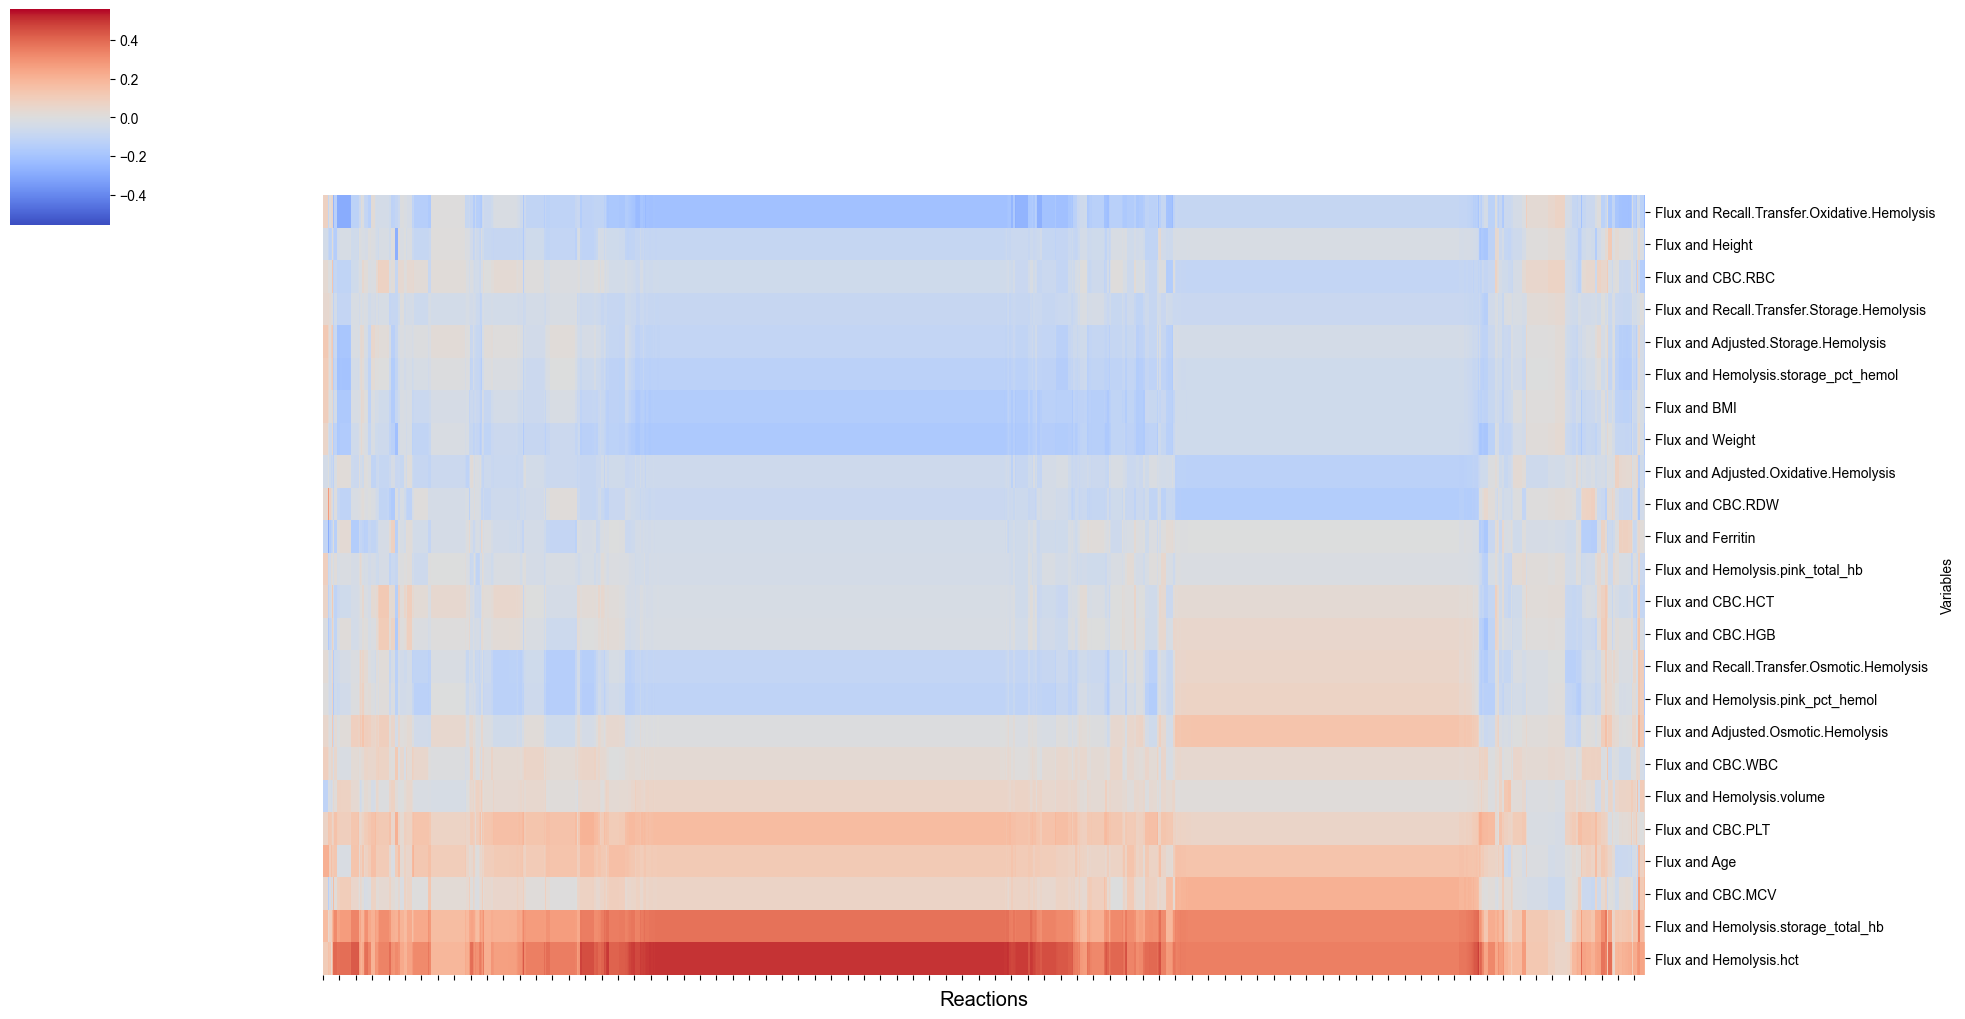

In [26]:
dtype = "Flux"
df_dtype = df_all_correlations.dropna().copy()
if "Flux and Abundance" in df_dtype.columns:
    df_dtype = df_dtype.drop("Flux and Abundance", level=0, axis=1)
df_dtype = df_dtype.loc[
    :, [x for x in df_dtype.columns if x[0].startswith(dtype) or x[0] in cat_cols]
]
df_dtype.to_csv(
    dataset_path
    / f"{pcmodel.id}_{dataset_name}_METADATA_{dtype.upper()}_CORRELATIONS.tsv",
    sep="\t",
    index=True,
)
df_dtype = df_dtype.loc[
    :, [x for x in df_dtype.columns if x[1] == "rho" or x[0] in cat_cols]
].droplevel(1, axis=1)
df_dtype

df_data = df_dtype.droplevel(1, axis=0)
df_data = df_data.loc[
    sorted(
        df_data.index,
        key=lambda x: (mapping_dict[model.reactions.get_by_id(x).subsystem], x),
    )
].T
df_data = df_data.loc[~df_data.index.isin(cat_cols)].astype(float)

# Cant exceed absolute value of 1
rho_lim = min(df_data.abs().max().max() * 1.1, 1)
fig = sns.clustermap(
    df_data,
    figsize=(20, 0.5 * len(df_data.index)),
    cmap="coolwarm",
    row_cluster=row_cluster,
    col_cluster=col_cluster,
    vmin=-rho_lim,
    vmax=rho_lim,
    row_linkage=linkage(
        df_data, method=row_method, metric=row_metric, optimal_ordering=optimal_ordering
    ),
    col_linkage=linkage(
        df_data.T,
        method=col_method,
        metric=col_metric,
        optimal_ordering=optimal_ordering,
    ),
    # col_colors=[category_colors[mapping_dict[model.reactions.get_by_id(x).subsystem]] for x in df_data.columns],
)
ax_heatmap = fig.ax_heatmap
ax_heatmap.set_xlabel("Reactions", fontsize="x-large")
ax_heatmap.xaxis.set_ticklabels([])
fig.ax_row_dendrogram.set_visible(False)
fig.ax_col_dendrogram.set_visible(False)
fig;

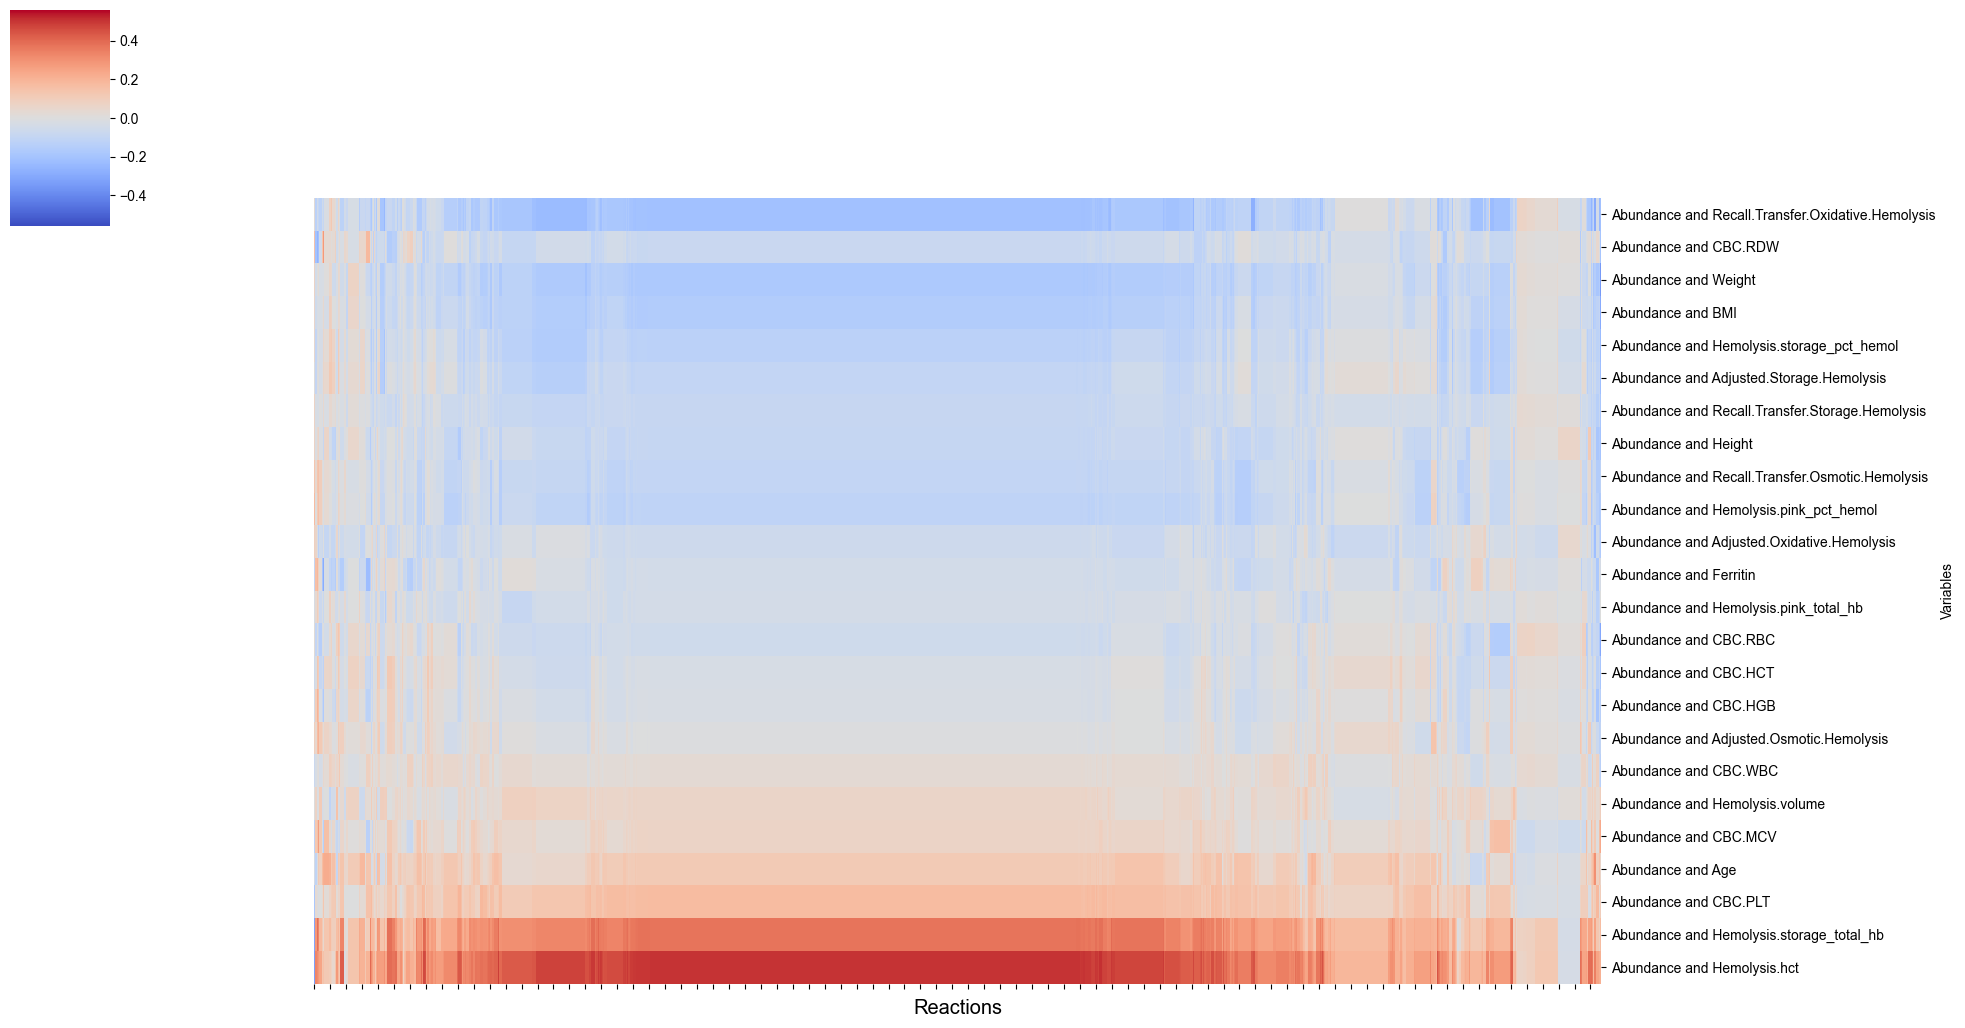

In [27]:
dtype = "Abun"
df_dtype = df_all_correlations.dropna().copy()
if "Flux and Abundance" in df_dtype.columns:
    df_dtype = df_dtype.drop("Flux and Abundance", level=0, axis=1)
df_dtype = df_dtype.loc[
    :, [x for x in df_dtype.columns if x[0].startswith(dtype) or x[0] in cat_cols]
]
df_dtype.to_csv(
    dataset_path
    / f"{pcmodel.id}_{dataset_name}_METADATA_{dtype.upper()}_CORRELATIONS.tsv",
    sep="\t",
    index=True,
)
df_dtype = df_dtype.loc[
    :, [x for x in df_dtype.columns if x[1] == "rho" or x[0] in cat_cols]
].droplevel(1, axis=1)
df_dtype

df_data = df_dtype.droplevel(1, axis=0)
df_data = df_data.loc[
    sorted(
        df_data.index,
        key=lambda x: (mapping_dict[model.reactions.get_by_id(x).subsystem], x),
    )
].T
df_data = df_data.loc[~df_data.index.isin(cat_cols)].astype(float)

# Cant exceed absolute value of 1
rho_lim = min(df_data.abs().max().max() * 1.1, 1)
fig = sns.clustermap(
    df_data,
    figsize=(20, 0.5 * len(df_data.index)),
    cmap="coolwarm",
    row_cluster=row_cluster,
    col_cluster=col_cluster,
    vmin=-rho_lim,
    vmax=rho_lim,
    row_linkage=linkage(
        df_data, method=row_method, metric=row_metric, optimal_ordering=optimal_ordering
    ),
    col_linkage=linkage(
        df_data.T,
        method=col_method,
        metric=col_metric,
        optimal_ordering=optimal_ordering,
    ),
    # col_colors=[category_colors[mapping_dict[model.reactions.get_by_id(x).subsystem]] for x in df_data.columns],
)
ax_heatmap = fig.ax_heatmap
ax_heatmap.set_xlabel("Reactions", fontsize="x-large")
ax_heatmap.xaxis.set_ticklabels([])
ax_heatmap.xaxis.set_tick_params(labelsize="x-large")
fig.ax_row_dendrogram.set_visible(False)
fig.ax_col_dendrogram.set_visible(False)

if save_figures:
    fig.savefig(
        results_path / f"MetaDataCorr_{model.id}.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

#### Visualize correlations with metadata

In [28]:
# Consistent plot dimensions and values
pvalue_tol = 1e-320
scatter_inch = 5  # Length x width of scatter plot
hist_inch = 1  # Length or width of histogram addition
hist_pad = 0.4  # Space between scatter and histogram
cmap = "viridis"
edgecolor = "black"
edgewidth = 0.5
grid = False
zorder = 2
histx = True
histy = True

##### Age

Variables                                   Flux and Age              
Spearman correlation                                 rho        pvalue
reaction    genes                                                     
ASNTA       PSAT1                               0.216615  4.613272e-21
OXOSUCAH    NIT2                                0.216615  4.613272e-21
ERTHSD_Dy   SORD                                0.212072  3.098988e-20
SBTD_D2     SORD                                0.212072  3.098988e-20
XYLTD_Dx    SORD                                0.212072  3.098988e-20
E4PP        ARMT1                               0.212072  3.098988e-20
SBTRa       AKR1A1;AKR1B1;AKR7A2                0.212072  3.098988e-20
ANDRSTNDNRy AKR1C3;DHRS11;HSD17B12              0.199805  4.280805e-18
ESTRONEDHy  AKR1C3;DHRS11;HSD17B11;HSD17B12     0.194155  3.732259e-17
PRGSTRNRy   AKR1C3;DHRS11                       0.180712  4.966058e-15

Variables             Abundance and Age              
Spearman correlation  

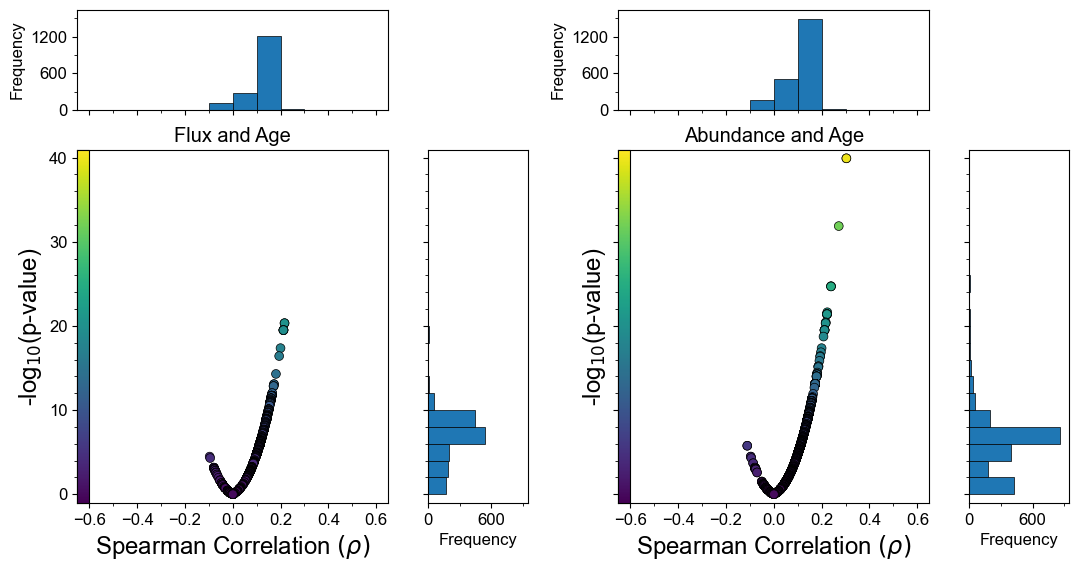

In [29]:
metadata_col = "Age"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)

print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### BMI

Variables                    Flux and BMI              
Spearman correlation                  rho        pvalue
reaction   genes                                       
GUAt       SLC29A1;SLC43A3      -0.179209  8.387390e-15
NTDCMP     NT5C3A               -0.177258  1.644923e-14
NTDUMP     NT5C3A               -0.177258  1.644923e-14
THYMt      SLC29A1;SLC43A3      -0.173178  6.564093e-14
URAt       SLC29A1;SLC43A3      -0.173178  6.564093e-14
2DURIt     SLC29A1              -0.172961  7.058518e-14
THYMDt     SLC29A1              -0.172961  7.058518e-14
NTDDTMP    HDDC2;NT5C;NT5C3A    -0.172961  7.058518e-14
DTMPCYTDPT NT5C3A               -0.172961  7.058518e-14
DTMPURIPT  NT5C3A               -0.172961  7.058518e-14

Variables             Abundance and BMI              
Spearman correlation                rho        pvalue
reaction  genes                                      
ARGN      ARG1                -0.294470  2.742230e-38
FISC      FTH1;FTL            -0.183912  1.602556e-15
S

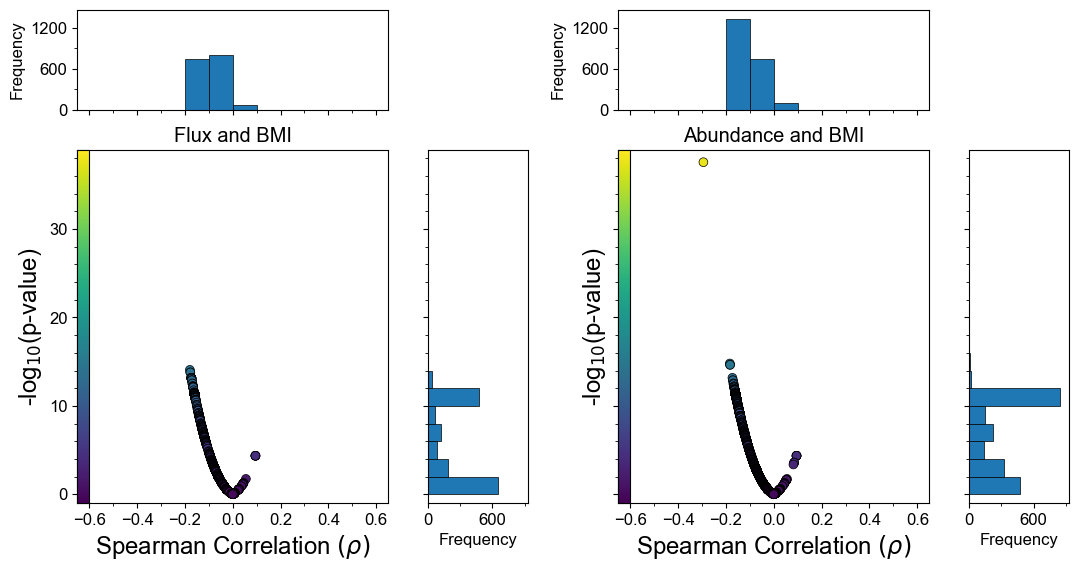

In [30]:
metadata_col = "BMI"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Weight

Variables                                                      Flux and Weight  \
Spearman correlation                                                       rho   
reaction    genes                                                                
UBIQE1ACT   UBA1;UBA6                                                -0.214307   
UBIQE1T     CDC34;UBE2O                                              -0.214307   
UBIQE2CONJT CUL1;CUL2;CUL3;CUL4A;CUL4B;CUL5;DCAF11;DCAF6;DC...       -0.214307   
UBIQE1E2T   CDC34;UBE2L3;UBE2N;UBE2V1;UBE2V2                         -0.214307   
PRPPS       PRPS1;PRPS1L1;PRPS2                                      -0.194536   
ADPGK       ADPGK                                                    -0.191225   
2LACK_L     PKLR;PKM                                                 -0.191128   
PGLYCK      PKLR;PKM                                                 -0.191128   
PYK         PKLR;PKM                                                 -0.191128   
2LACP_L     PGP 

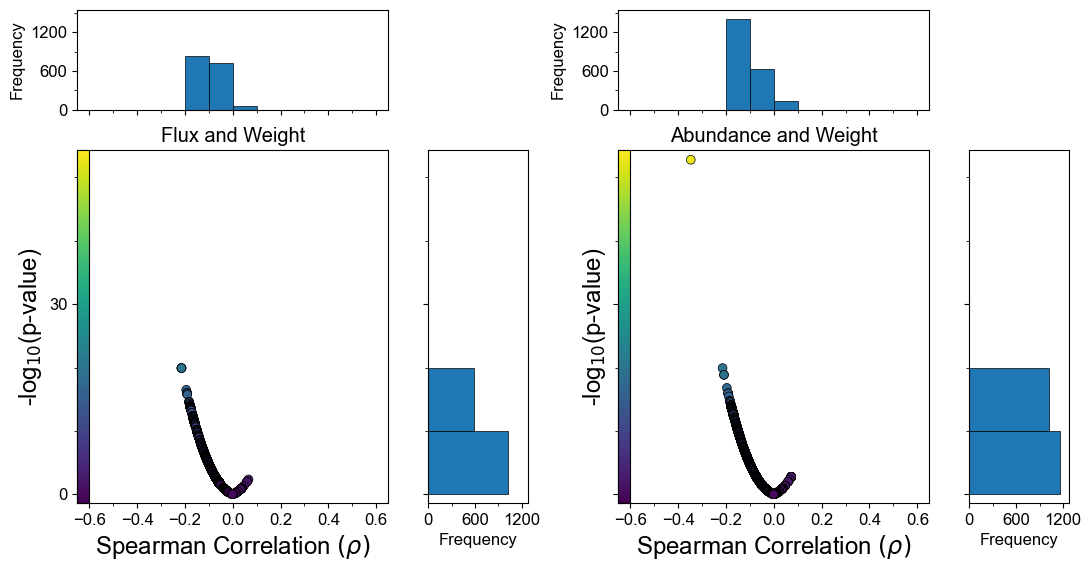

In [31]:
metadata_col = "Weight"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=30,
    ytick_minor=10,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Height

Variables                                                      Flux and Height  \
Spearman correlation                                                       rho   
reaction    genes                                                                
UBIQE1ACT   UBA1;UBA6                                                -0.282612   
UBIQE1T     CDC34;UBE2O                                              -0.282612   
UBIQE2CONJT CUL1;CUL2;CUL3;CUL4A;CUL4B;CUL5;DCAF11;DCAF6;DC...       -0.282612   
UBIQE1E2T   CDC34;UBE2L3;UBE2N;UBE2V1;UBE2V2                         -0.282612   
PRPPS       PRPS1;PRPS1L1;PRPS2                                      -0.197798   
2LACK_L     PKLR;PKM                                                 -0.190793   
PGLYCK      PKLR;PKM                                                 -0.190793   
PYK         PKLR;PKM                                                 -0.190793   
2LACP_L     PGP                                                      -0.190793   
PGLYCP      PGP 

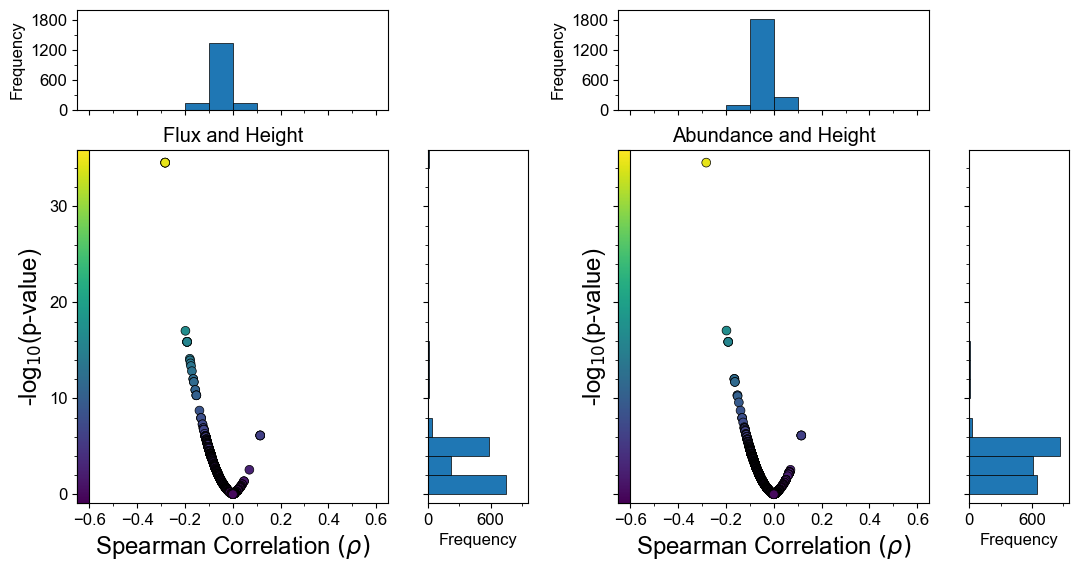

In [32]:
metadata_col = "Height"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Hemolysis.volume

Variables                            Flux and Hemolysis.volume              
Spearman correlation                                       rho        pvalue
reaction     genes                                                          
SPODM        SOD1                                     0.147587  1.827705e-10
FUMAC        FAH                                      0.140370  1.359189e-09
MACACI       GSTZ1                                    0.140370  1.359189e-09
TYRTA        GOT1;GOT2                                0.140370  1.359189e-09
ACACt2       BSG;EMB;SLC16A1;SLC16A7                  0.124625  7.667950e-08
BUT_ACACtex  BSG;EMB;SLC16A1;SLC16A7                  0.124625  7.667950e-08
LLAC_ACACtex BSG;EMB;SLC16A1;SLC16A7                  0.124625  7.667950e-08
PPA_ACACtex  BSG;EMB;SLC16A1;SLC16A7                  0.124625  7.667950e-08
PYR_ACACtex  BSG;EMB;SLC16A1;SLC16A7                  0.124625  7.667950e-08
ERTHSD_Dy    SORD                                    -0.114574  7.880451e-07

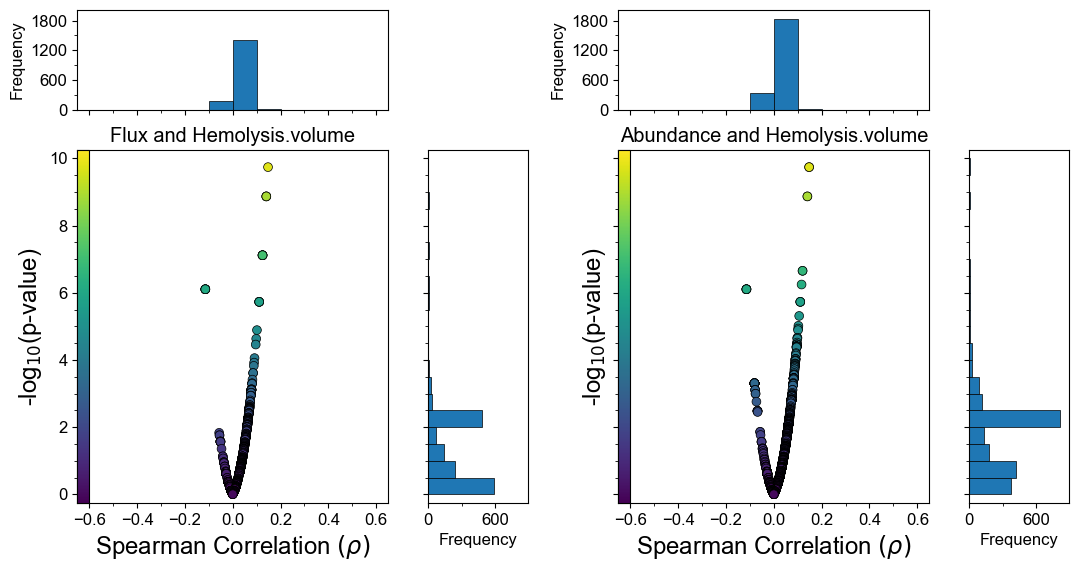

In [33]:
metadata_col = "Hemolysis.volume"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Hemolysis.hct

Variables                                                     Flux and Hemolysis.hct  \
Spearman correlation                                                             rho   
reaction   genes                                                                       
HCYSte     SLC3A2;SLC43A1;SLC43A2;SLC7A5                                    0.506396   
KCC2t      SLC12A4;SLC12A6;SLC12A7                                          0.503949   
KCCt       SLC12A4;SLC12A6;SLC12A7                                          0.503949   
LHCYSTINt  SLC3A2;SLC43A1;SLC43A2;SLC7A5                                    0.502425   
MG2tec     GRIA1;PIEZO1;VDAC1                                               0.502260   
MG2NAtex2  SLC41A1                                                          0.502260   
NAt        GRIA1;P2RX1;P2RX2;P2RX7;PANX1;PIEZO1;SCN4A;SCN9...               0.501999   
TMASCBOXt  CYB561D2;CYBRD1                                                  0.501602   
TMASCBOXt2 CYB561D2;CYBRD1      

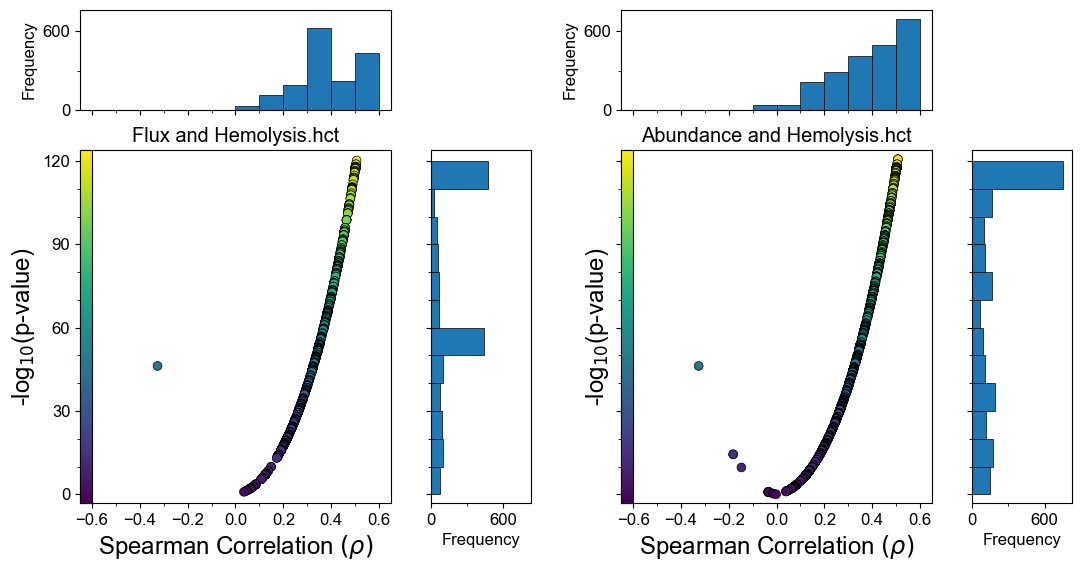

In [34]:
metadata_col = "Hemolysis.hct"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=30,
    ytick_minor=10,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)

axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Hemolysis.storage_total_hb

Variables                         Flux and Hemolysis.storage_total_hb  \
Spearman correlation                                              rho   
reaction       genes                                                    
PESCRt         PLSCR1;PLSCR4                                 0.399436   
GLUN           CTPS1;CTPS2;GMPS                              0.393675   
NADK           NADK2                                         0.393016   
NADPHPPS       HDDC3                                         0.393016   
PSSCRt         ANO6;PLSCR1;PLSCR4                            0.389590   
PROTGMT        ARMT1                                         0.384865   
R5PP           ARMT1                                         0.384865   
GAPP           ARMT1                                         0.384445   
5FTHF_THMMPtex SLC19A1                                       0.383936   
5MTHF_THMMPtex SLC19A1                                       0.383936   

Variables                                        


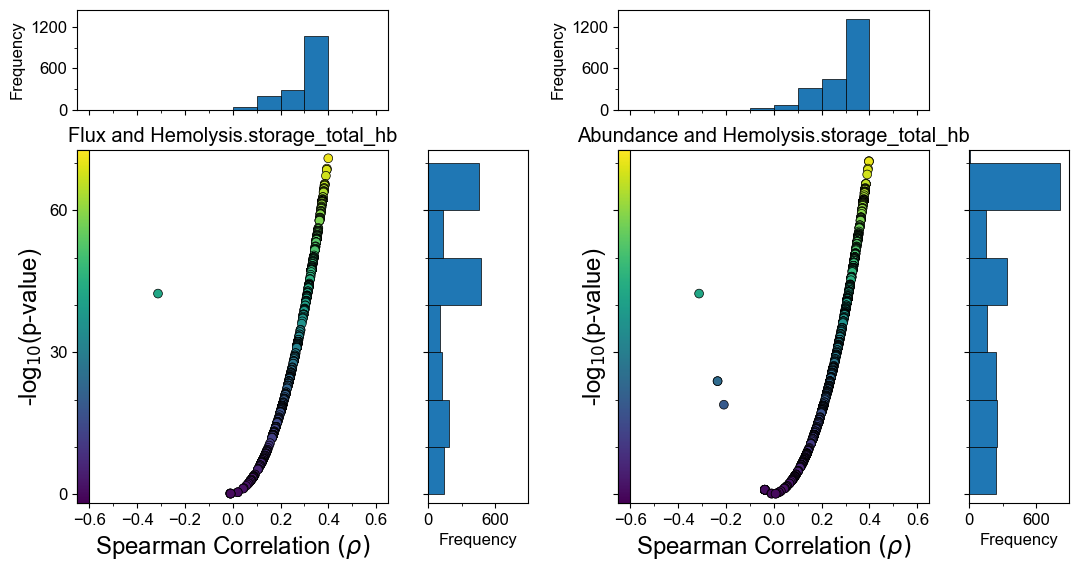

In [35]:
metadata_col = "Hemolysis.storage_total_hb"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=30,
    ytick_minor=10,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Hemolysis.storage_pct_hemol

Variables                    Flux and Hemolysis.storage_pct_hemol  \
Spearman correlation                                          rho   
reaction   genes                                                    
GUAt       SLC29A1;SLC43A3                              -0.211201   
NTDCMP     NT5C3A                                       -0.207799   
NTDUMP     NT5C3A                                       -0.207799   
2DURIt     SLC29A1                                      -0.200304   
THYMDt     SLC29A1                                      -0.200304   
NTDDTMP    HDDC2;NT5C;NT5C3A                            -0.200304   
DTMPCYTDPT NT5C3A                                       -0.200304   
DTMPURIPT  NT5C3A                                       -0.200304   
DUMPCYTDPT NT5C3A                                       -0.200304   
DUMPURIPT  NT5C3A                                       -0.200304   

Variables                                   
Spearman correlation                pvalue  
reaction   g

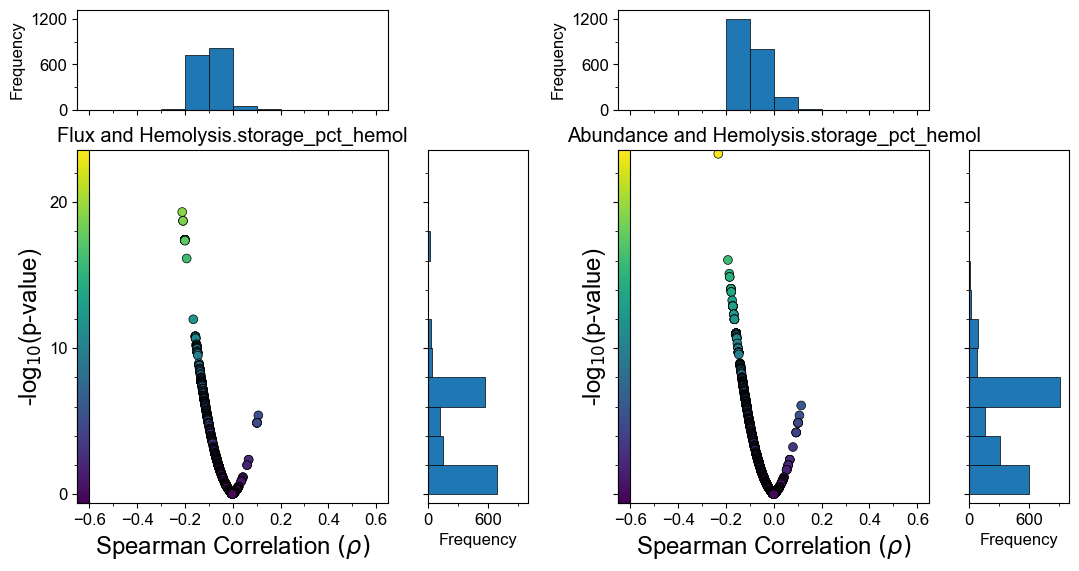

In [36]:
metadata_col = "Hemolysis.storage_pct_hemol"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Hemolysis.pink_total_hb

Variables                        Flux and Hemolysis.pink_total_hb  \
Spearman correlation                                          rho   
reaction genes                                                      
2LACK_L  PKLR;PKM                                       -0.136517   
PGLYCK   PKLR;PKM                                       -0.136517   
PYK      PKLR;PKM                                       -0.136517   
2LACP_L  PGP                                            -0.136517   
PGLYCP   PGP                                            -0.136517   
RPE      RPE                                            -0.126059   
RPI      RPIA                                           -0.121495   
GTHOx    GSR                                            -0.107490   
GTHOy    GSR                                            -0.107490   
NO3t     CLCN2;CLIC1;CLIC4;PANX1                        -0.105866   

Variables                                       
Spearman correlation                    pvalue  
reac

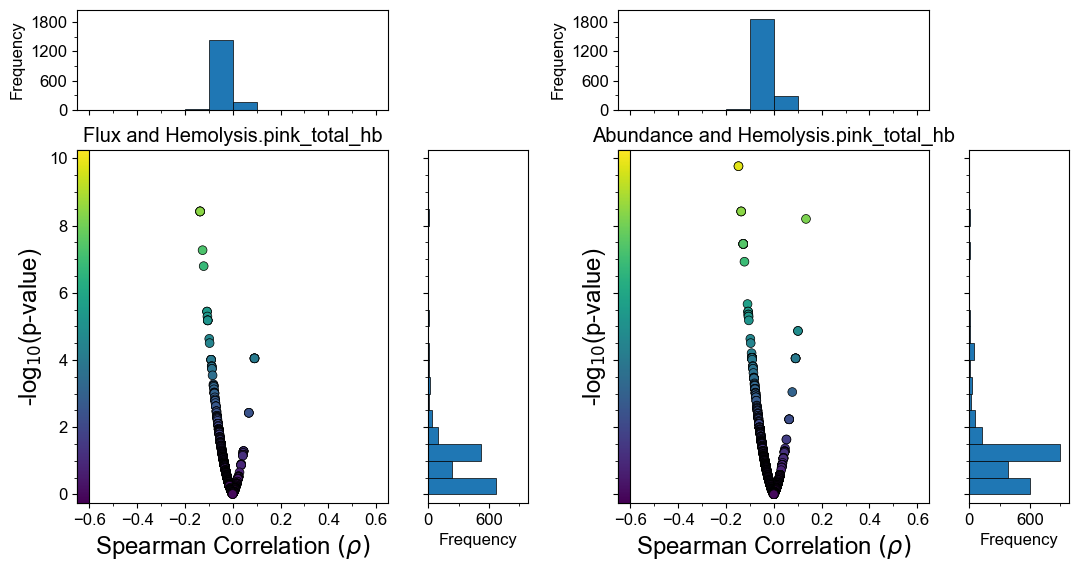

In [37]:
metadata_col = "Hemolysis.pink_total_hb"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = round(
        max(df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max())
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Hemolysis.pink_pct_hemol

Variables                   Flux and Hemolysis.pink_pct_hemol              
Spearman correlation                                      rho        pvalue
reaction    genes                                                          
SELDIGTHOXy GPX1                                    -0.176624  2.043955e-14
SELGTHGTHR  GPX1                                    -0.176624  2.043955e-14
FE3t        TF;TFR2;TFRC                             0.172430  8.429233e-14
GTHP        GPX1;GPX4                               -0.167039  4.948284e-13
34DHALDDx   ALDH3A1;ALDH3B1                         -0.156297  1.418766e-11
3M4HDXPACx  ALDH3A1;ALDH3B1                         -0.156297  1.418766e-11
34DHALDDy   ALDH3A1;ALDH3B1                         -0.155836  1.630293e-11
3M4HDXPACy  ALDH3A1;ALDH3B1                         -0.155836  1.630293e-11
34DHPHAMT   COMT                                    -0.155836  1.630293e-11
H2Ot        AQP1;AQP3                               -0.155477  1.816459e-11

Variables  

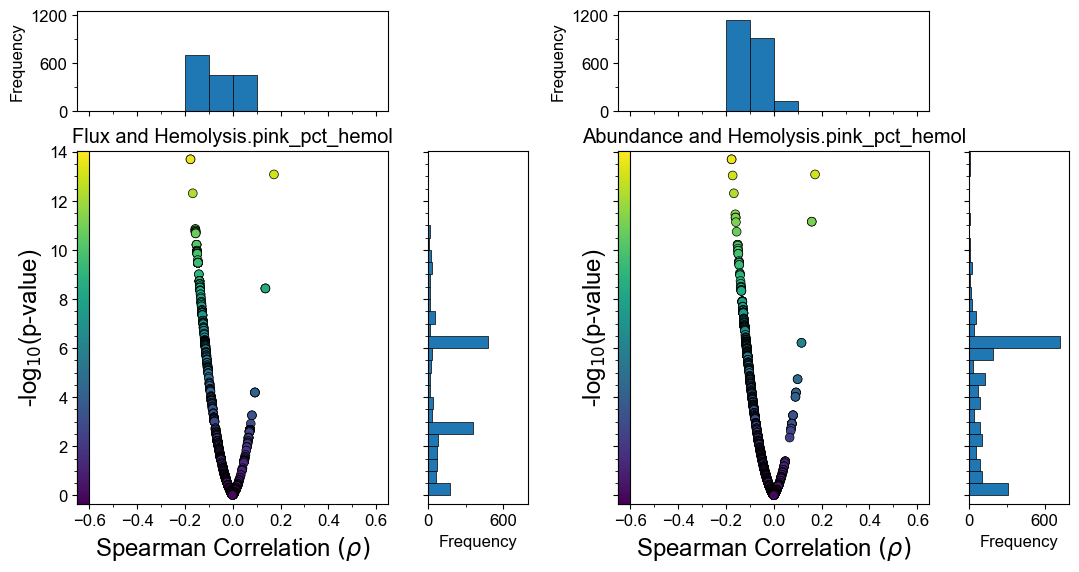

In [38]:
metadata_col = "Hemolysis.pink_pct_hemol"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Recall.Transfer.Storage.Hemolysis

Variables            Flux and Recall.Transfer.Storage.Hemolysis              
Spearman correlation                                        rho        pvalue
reaction genes                                                               
2LACK_L  PKLR;PKM                                     -0.141782  1.225542e-09
PGLYCK   PKLR;PKM                                     -0.141782  1.225542e-09
PYK      PKLR;PKM                                     -0.141782  1.225542e-09
2LACP_L  PGP                                          -0.141782  1.225542e-09
PGLYCP   PGP                                          -0.141782  1.225542e-09
RPE      RPE                                          -0.129619  2.841951e-08
RPI      RPIA                                         -0.125614  7.532017e-08
GTHP     GPX1;GPX4                                    -0.114784  9.058537e-07
GLCM     GALM                                         -0.110805  2.139948e-06
NADPHXE  NAXE                                         -0.110371 

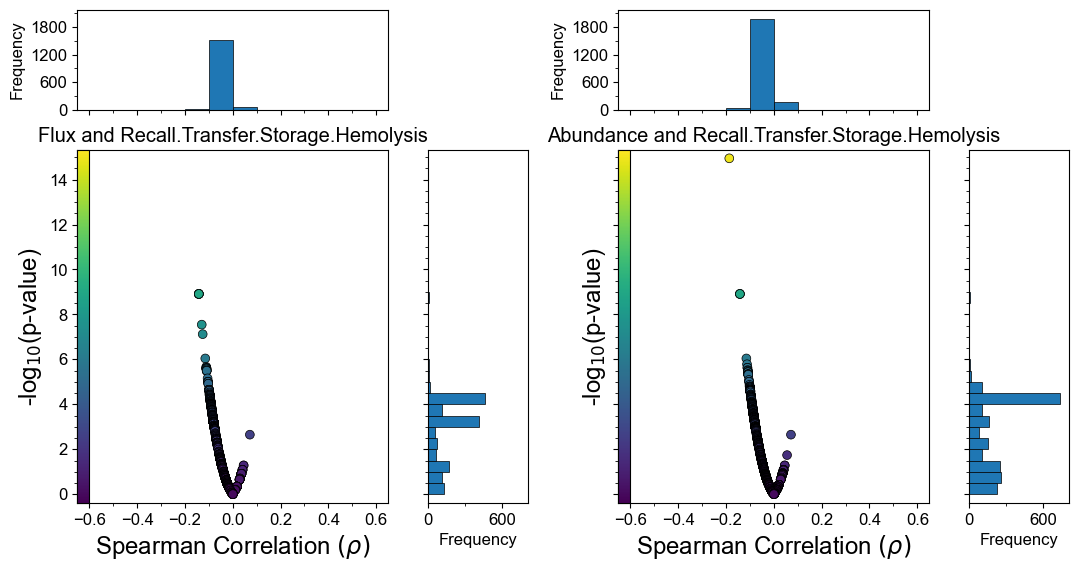

In [39]:
metadata_col = "Recall.Transfer.Storage.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Recall.Transfer.Osmotic.Hemolysis

Variables                 Flux and Recall.Transfer.Osmotic.Hemolysis  \
Spearman correlation                                             rho   
reaction        genes                                                  
SELDIGTHOXy     GPX1                                       -0.159353   
SELGTHGTHR      GPX1                                       -0.159353   
2LACK_L         PKLR;PKM                                   -0.157397   
PGLYCK          PKLR;PKM                                   -0.157397   
PYK             PKLR;PKM                                   -0.157397   
2LACP_L         PGP                                        -0.157397   
PGLYCP          PGP                                        -0.157397   
GLCM            GALM                                       -0.151649   
GTHP            GPX1;GPX4                                  -0.151394   
CHOLATEGTHABCte ABCC4                                      -0.147883   

Variables                                
Spearman correlation 

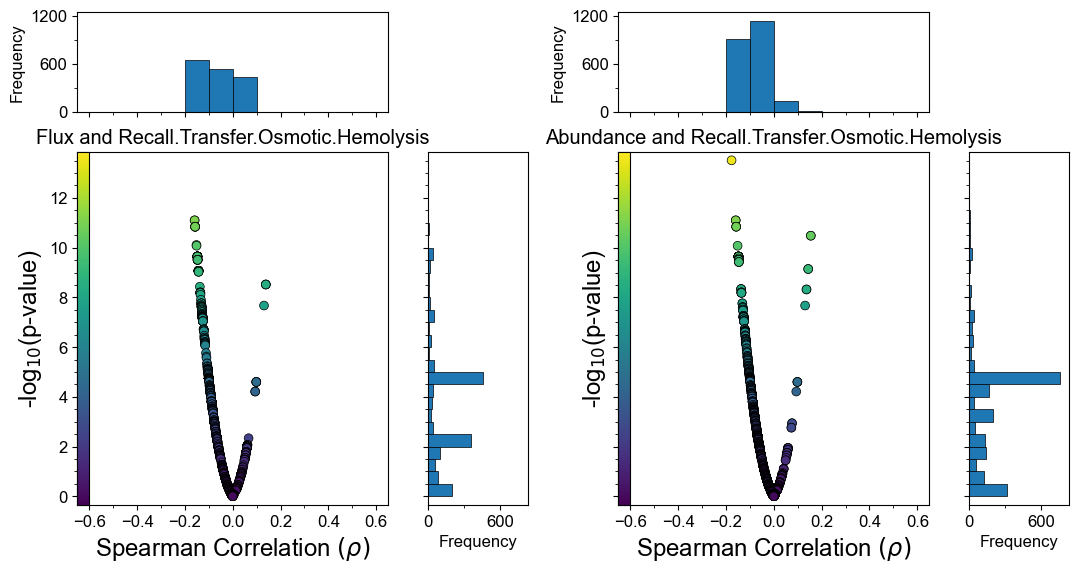

In [40]:
metadata_col = "Recall.Transfer.Osmotic.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Recall.Transfer.Oxidative.Hemolysis

Variables                    Flux and Recall.Transfer.Oxidative.Hemolysis  \
Spearman correlation                                                  rho   
reaction   genes                                                            
NTDCMP     NT5C3A                                               -0.288963   
NTDUMP     NT5C3A                                               -0.288963   
THYMt      SLC29A1;SLC43A3                                      -0.288891   
URAt       SLC29A1;SLC43A3                                      -0.288891   
2DURIt     SLC29A1                                              -0.288765   
THYMDt     SLC29A1                                              -0.288765   
NTDDTMP    HDDC2;NT5C;NT5C3A                                    -0.288765   
DTMPCYTDPT NT5C3A                                               -0.288765   
DTMPURIPT  NT5C3A                                               -0.288765   
DUMPCYTDPT NT5C3A                                               -0.288765   

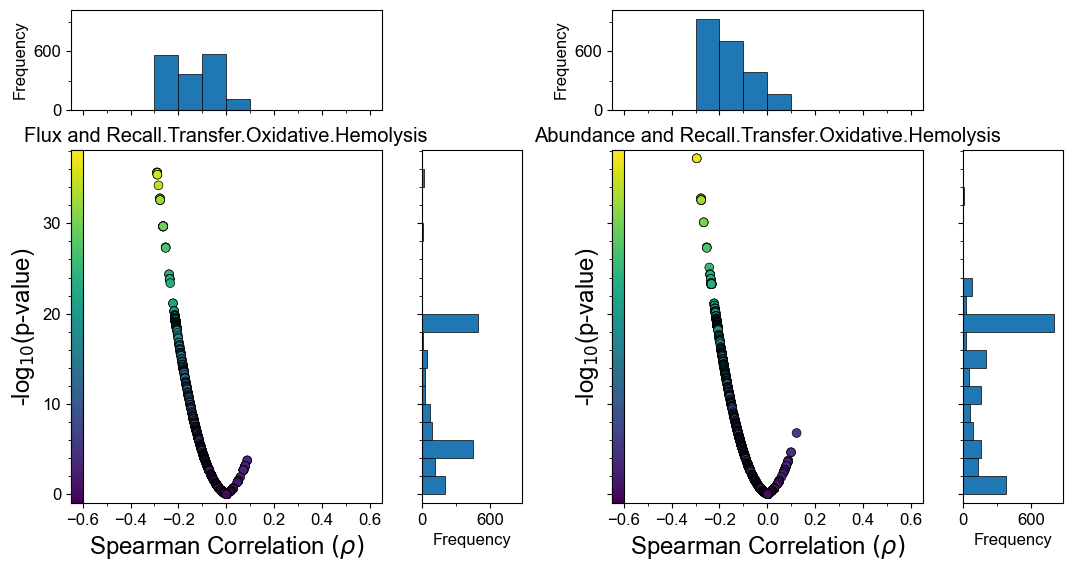

In [41]:
metadata_col = "Recall.Transfer.Oxidative.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Adjusted.Storage.Hemolysis

Variables                    Flux and Adjusted.Storage.Hemolysis              
Spearman correlation                                         rho        pvalue
reaction   genes                                                              
GUAt       SLC29A1;SLC43A3                             -0.200039  4.158214e-18
NTDCMP     NT5C3A                                      -0.196202  1.821420e-17
NTDUMP     NT5C3A                                      -0.196202  1.821420e-17
2DURIt     SLC29A1                                     -0.187862  4.072442e-16
THYMDt     SLC29A1                                     -0.187862  4.072442e-16
NTDDTMP    HDDC2;NT5C;NT5C3A                           -0.187862  4.072442e-16
DTMPCYTDPT NT5C3A                                      -0.187862  4.072442e-16
DTMPURIPT  NT5C3A                                      -0.187862  4.072442e-16
DUMPCYTDPT NT5C3A                                      -0.187862  4.072442e-16
DUMPURIPT  NT5C3A                                   

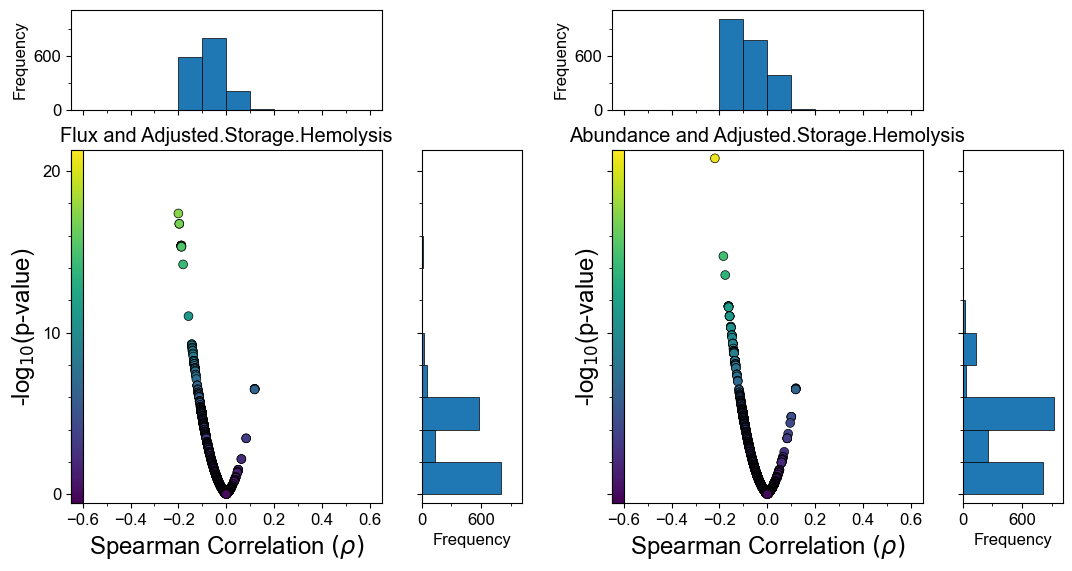

In [42]:
metadata_col = "Adjusted.Storage.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Adjusted.Osmotic.Hemolysis

Variables                  Flux and Adjusted.Osmotic.Hemolysis              
Spearman correlation                                       rho        pvalue
reaction genes                                                              
TKT1     TKT                                          0.192799  6.214799e-17
TKT2     TKT                                          0.192799  6.214799e-17
TALA     TALDO1                                       0.192799  6.214799e-17
PFK      PFKL;PFKM;PFKP                               0.152637  4.228601e-11
FBA      ALDOA;ALDOB;ALDOC                            0.152637  4.228601e-11
PROTNK1  NME1;NME2                                    0.140709  1.239917e-09
PROTNK2  NME1;NME2                                    0.140709  1.239917e-09
PI4K     PI4K2A;PI4KA                                 0.139294  1.817672e-09
DADNK1   ADK                                          0.139289  1.820285e-09
NRHK     ADK                                          0.139289  1.820285e-09

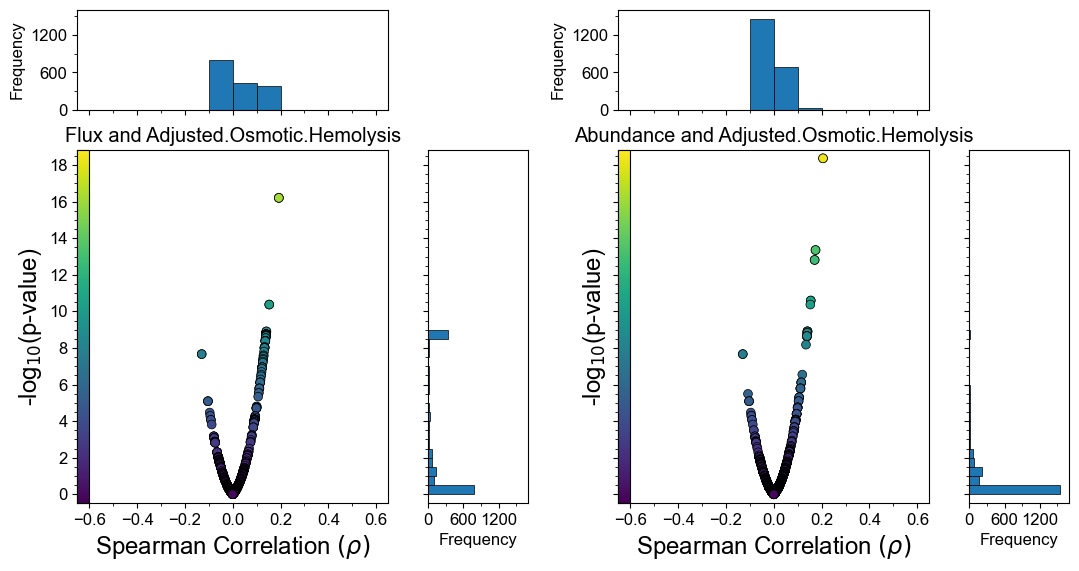

In [43]:
metadata_col = "Adjusted.Osmotic.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Adjusted.Oxidative.Hemolysis

Variables                                           Flux and Adjusted.Oxidative.Hemolysis  \
Spearman correlation                                                                  rho   
reaction           genes                                                                    
PGG1S              PTGS1;PTGS2                                                  -0.131887   
PGG3S              PTGS1;PTGS2                                                  -0.131887   
PGE1S              PTGES3                                                       -0.131887   
PGE3S              PTGES3                                                       -0.131887   
PGG1GTHR           GPX1;GPX4;PRDX6                                              -0.131887   
PGG3GTHR           GPX1;GPX4;PRDX6                                              -0.131887   
TKT1               TKT                                                          -0.131299   
TKT2               TKT                                                

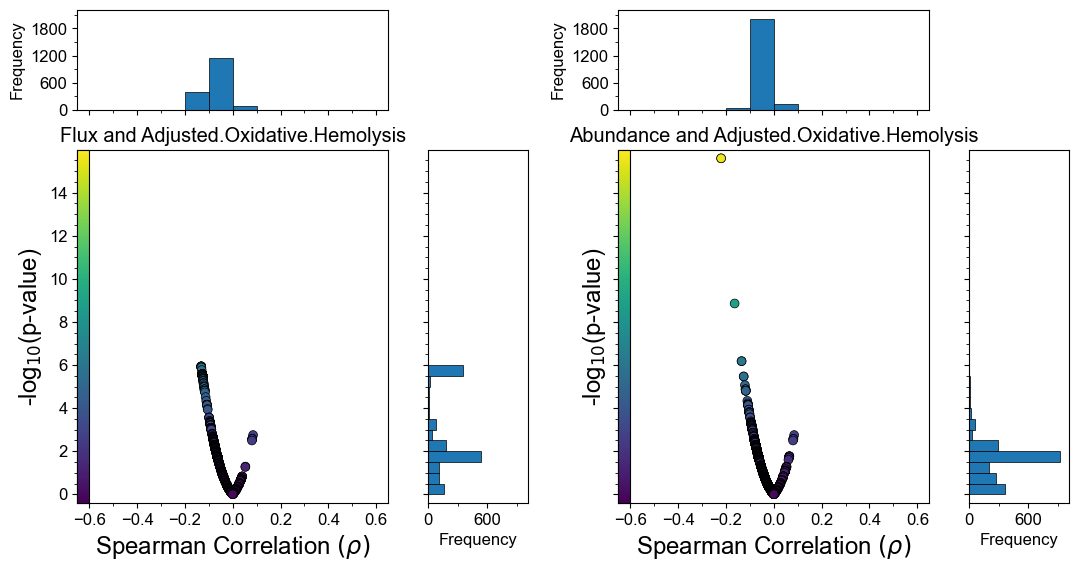

In [44]:
metadata_col = "Adjusted.Oxidative.Hemolysis"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### CBC.WBC

Variables                                                      Flux and CBC.WBC  \
Spearman correlation                                                        rho   
reaction    genes                                                                 
NAPRT       NAPRT                                                      0.118438   
NICHYD      NT5C;NT5C2                                                 0.118438   
UBIQE1ACT   UBA1;UBA6                                                  0.116029   
UBIQE1T     CDC34;UBE2O                                                0.116029   
UBIQE2CONJT CUL1;CUL2;CUL3;CUL4A;CUL4B;CUL5;DCAF11;DCAF6;DC...         0.116029   
UBIQE1E2T   CDC34;UBE2L3;UBE2N;UBE2V1;UBE2V2                           0.116029   
ERTHSD_Dy   SORD                                                       0.091256   
SBTD_D2     SORD                                                       0.091256   
XYLTD_Dx    SORD                                                       0.091256   
E4PP

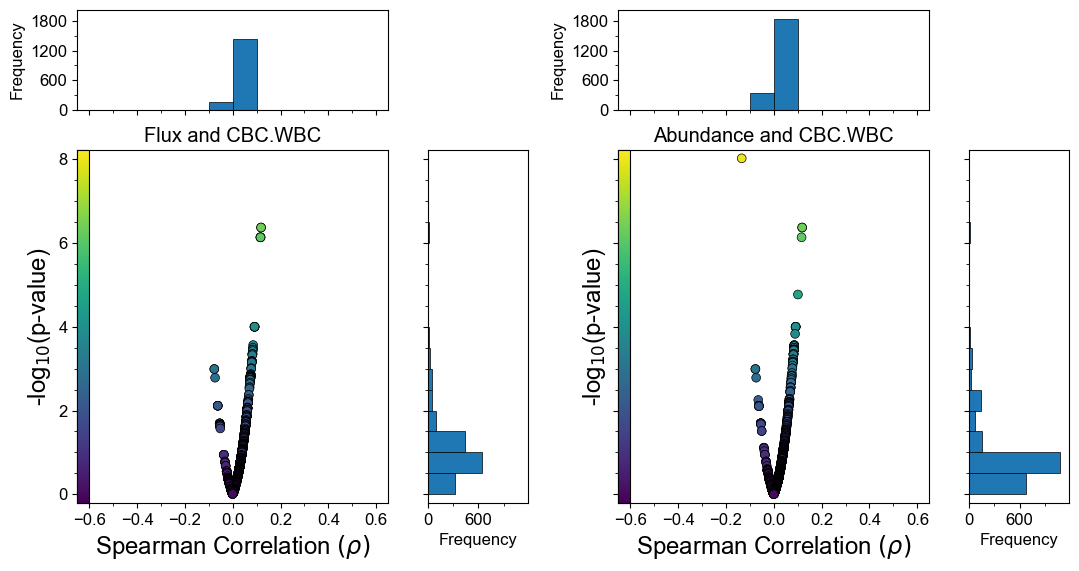

In [45]:
metadata_col = "CBC.WBC"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### CBC.RBC

Variables            Flux and CBC.RBC              
Spearman correlation              rho        pvalue
reaction    genes                                  
SELDIGTHOXy GPX1            -0.167146  8.037236e-13
SELGTHGTHR  GPX1            -0.167146  8.037236e-13
2DADNt      SLC29A1         -0.158370  1.205066e-11
CYTDt       SLC29A1         -0.156583  2.053751e-11
THBPTt      SLC29A1         -0.156583  2.053751e-11
78DHBPTt    SLC29A1         -0.156571  2.061102e-11
SPPTt       SLC29A1         -0.156571  2.061102e-11
SPPTDH      CBR1            -0.156571  2.061102e-11
DRPA        DERA            -0.156286  2.243169e-11
URIt        SLC29A1         -0.155945  2.480551e-11

Variables            Abundance and CBC.RBC              
Spearman correlation                   rho        pvalue
reaction    genes                                       
ARGN        ARG1                 -0.301823  1.775037e-39
SELDIGTHOXy GPX1                 -0.167146  8.037236e-13
SELGTHGTHR  GPX1                 -0.16

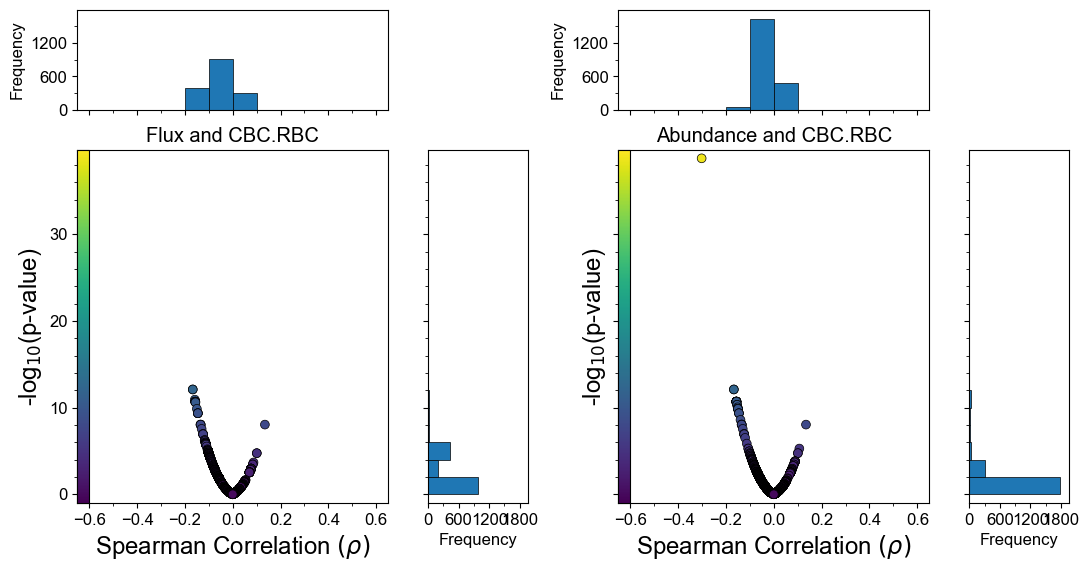

In [46]:
metadata_col = "CBC.RBC"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### CBC.HGB

Variables                                                      Flux and CBC.HGB  \
Spearman correlation                                                        rho   
reaction    genes                                                                 
2LACK_L     PKLR;PKM                                                  -0.192279   
PGLYCK      PKLR;PKM                                                  -0.192279   
PYK         PKLR;PKM                                                  -0.192279   
2LACP_L     PGP                                                       -0.192279   
PGLYCP      PGP                                                       -0.192279   
ASNTA       PSAT1                                                     -0.168797   
OXOSUCAH    NIT2                                                      -0.168797   
UBIQE1ACT   UBA1;UBA6                                                 -0.167973   
UBIQE1T     CDC34;UBE2O                                               -0.167973   
UBIQ

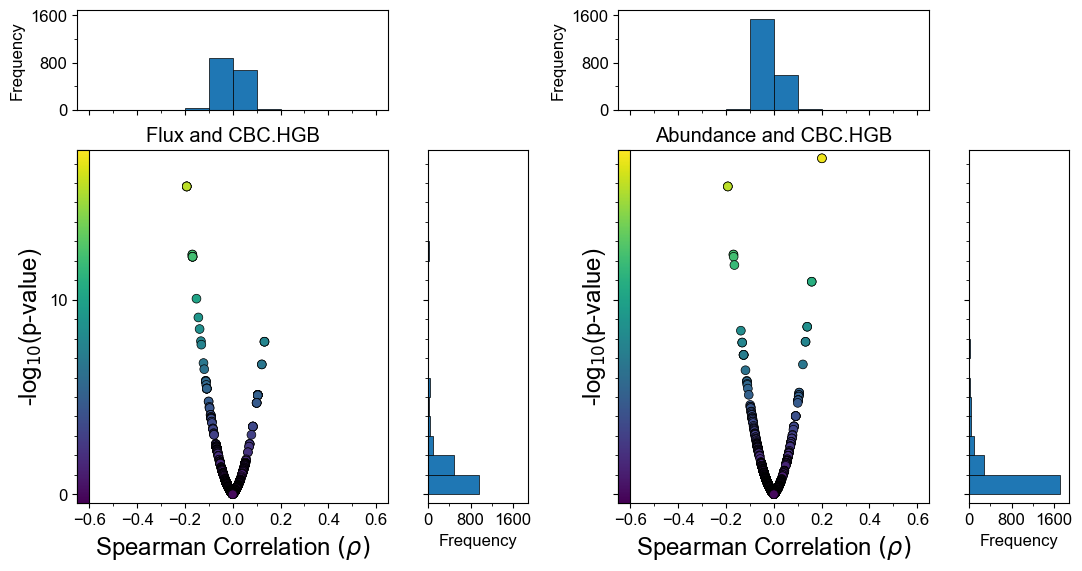

In [47]:
metadata_col = "CBC.HGB"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=800,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=1,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=800,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### CBC.HCT

Variables                                                      Flux and CBC.HCT  \
Spearman correlation                                                        rho   
reaction    genes                                                                 
UBIQE1ACT   UBA1;UBA6                                                 -0.140788   
UBIQE1T     CDC34;UBE2O                                               -0.140788   
UBIQE2CONJT CUL1;CUL2;CUL3;CUL4A;CUL4B;CUL5;DCAF11;DCAF6;DC...        -0.140788   
UBIQE1E2T   CDC34;UBE2L3;UBE2N;UBE2V1;UBE2V2                          -0.140788   
UREAt       SLC14A1                                                   -0.135255   
ARGN        ARG1                                                      -0.135255   
2LACK_L     PKLR;PKM                                                  -0.133350   
PGLYCK      PKLR;PKM                                                  -0.133350   
PYK         PKLR;PKM                                                  -0.133350   
2LAC

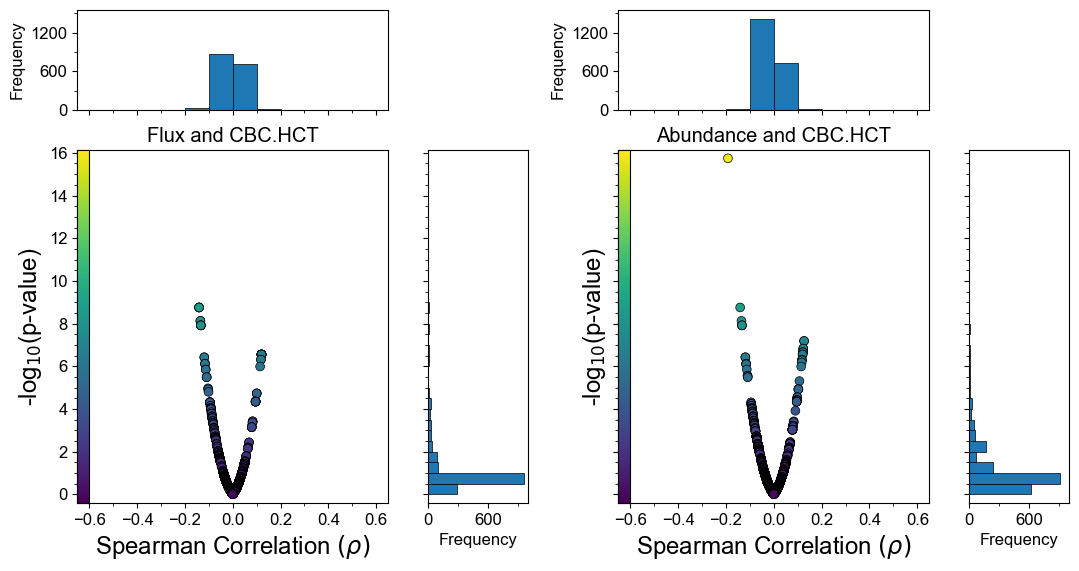

In [48]:
metadata_col = "CBC.HCT"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=2,
    ytick_minor=0.5,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)

if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### CBC.MCV

Variables               Flux and CBC.MCV              
Spearman correlation                 rho        pvalue
reaction genes                                        
TKT1     TKT                    0.252139  1.125577e-27
TKT2     TKT                    0.252139  1.125577e-27
TALA     TALDO1                 0.252139  1.125577e-27
PI4PP    SACM1L;SYNJ1           0.205303  1.071405e-18
PI4K     PI4K2A;PI4KA           0.205285  1.078783e-18
DADNK1   ADK                    0.205258  1.090170e-18
NRHK     ADK                    0.205258  1.090170e-18
NDPK7    NME1;NME2;NME3         0.205258  1.090170e-18
GK1      GUK1                   0.205258  1.090170e-18
GK2      GUK1                   0.205258  1.090170e-18

Variables             Abundance and CBC.MCV              
Spearman correlation                    rho        pvalue
reaction    genes                                        
HMBS        HMBS                   0.283273  8.750958e-35
TKT1        TKT                    0.270064  1.18417

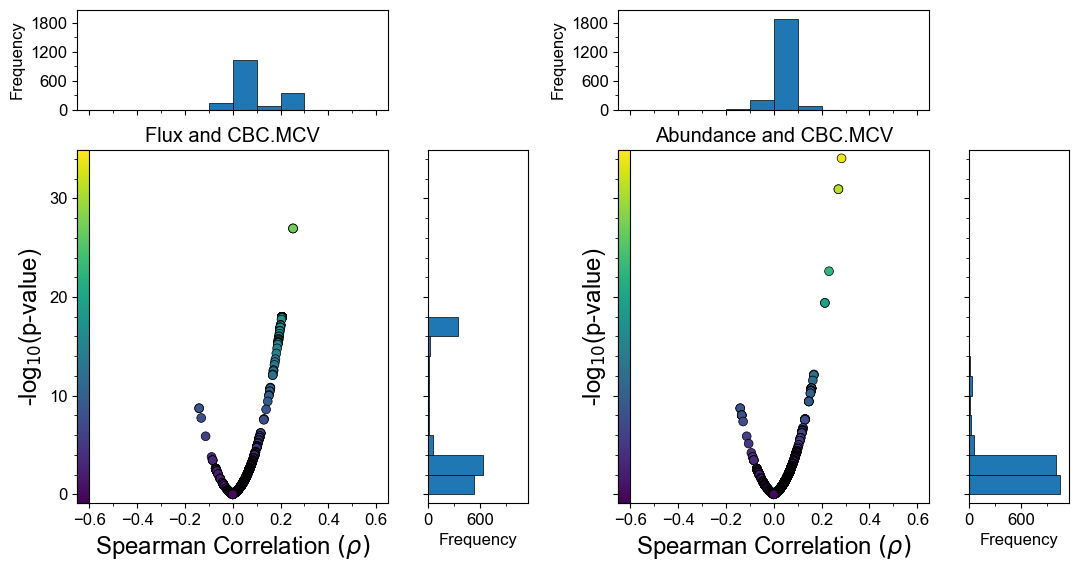

In [49]:
metadata_col = "CBC.MCV"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### CBC.RDW

Variables                           Flux and CBC.RDW              
Spearman correlation                             rho        pvalue
reaction    genes                                                 
ASNTA       PSAT1                           0.280373  4.408250e-34
OXOSUCAH    NIT2                            0.280373  4.408250e-34
TKT1        TKT                            -0.180622  9.399782e-15
TKT2        TKT                            -0.180622  9.399782e-15
TALA        TALDO1                         -0.180622  9.399782e-15
GOATA       GOT1;PSAT1                      0.179509  1.375584e-14
PRDX2OX1    PRDX1;PRDX2;PRDX4;PRDX5        -0.167952  6.221724e-13
PRDX2OX2    PRDX1;PRDX2;PRDX4;PRDX5        -0.167952  6.221724e-13
PRDX2SO2OX1 PRDX1;PRDX2;PRDX4              -0.167378  7.467713e-13
PRDX2SOOX1  PRDX1;PRDX2;PRDX4              -0.167378  7.467713e-13

Variables                    Abundance and CBC.RDW              
Spearman correlation                           rho        pvalu

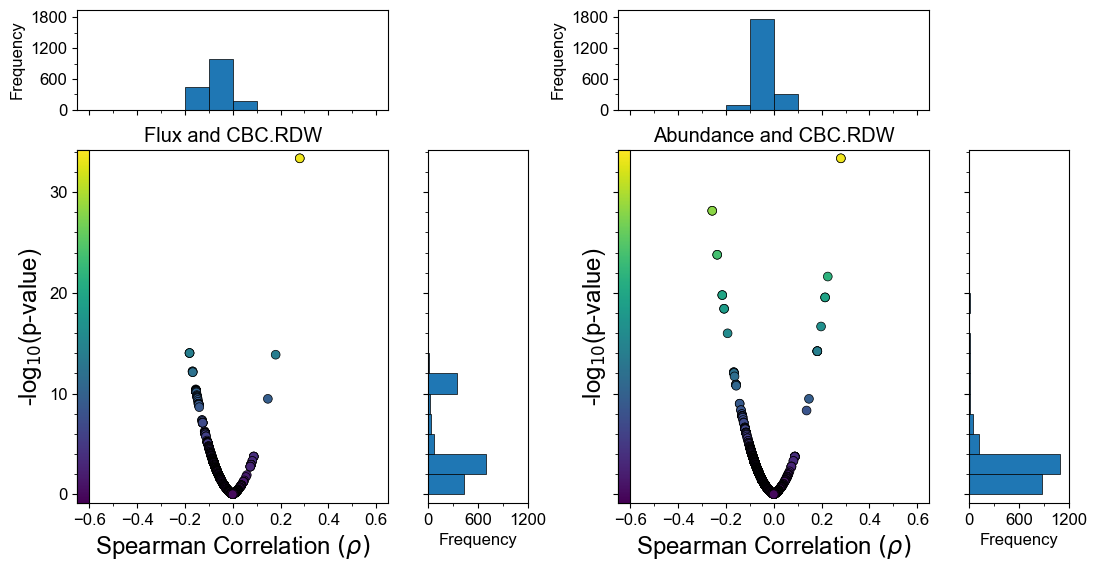

In [50]:
metadata_col = "CBC.RDW"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### CBC.PLT

Variables                                                      Flux and CBC.PLT  \
Spearman correlation                                                        rho   
reaction    genes                                                                 
PRPPS       PRPS1;PRPS1L1;PRPS2                                        0.220439   
ADPGK       ADPGK                                                      0.216772   
PGMTa       PGM1;PGM2                                                  0.213256   
GLCM        GALM                                                       0.211680   
UBIQE1ACT   UBA1;UBA6                                                  0.206705   
UBIQE1T     CDC34;UBE2O                                                0.206705   
UBIQE2CONJT CUL1;CUL2;CUL3;CUL4A;CUL4B;CUL5;DCAF11;DCAF6;DC...         0.206705   
UBIQE1E2T   CDC34;UBE2L3;UBE2N;UBE2V1;UBE2V2                           0.206705   
METHBHEMED  HBA;HBB;HBD;HBE1;HBG1;HBG2;HBM;HBQ1;HBZ                    0.204079   
CCLM

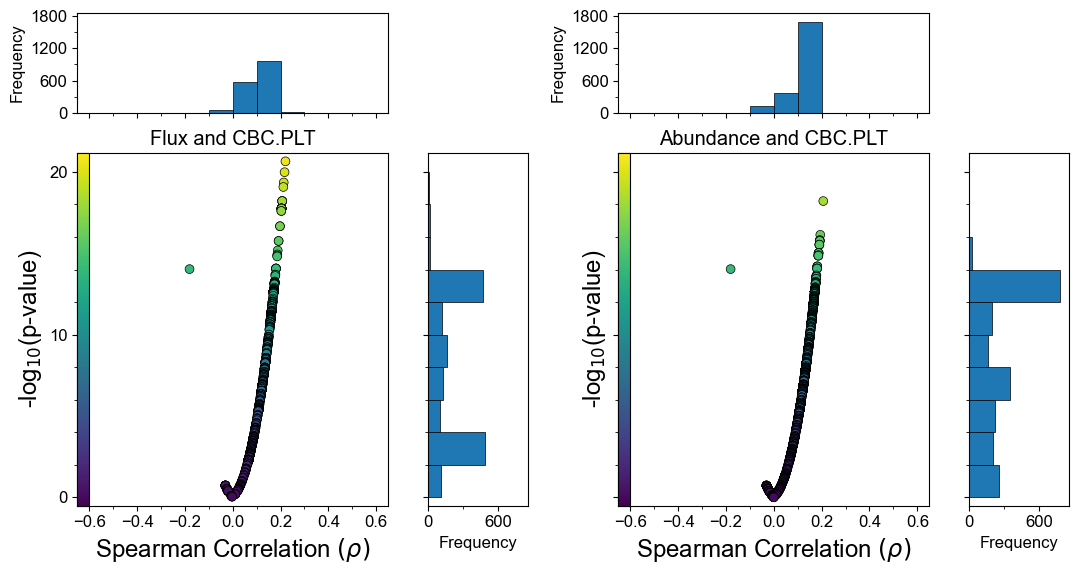

In [51]:
metadata_col = "CBC.PLT"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;

##### Ferritin

Variables            Flux and Ferritin              
Spearman correlation               rho        pvalue
reaction genes                                      
ASNTA    PSAT1               -0.291406  1.939310e-37
OXOSUCAH NIT2                -0.291406  1.939310e-37
GOATA    GOT1;PSAT1          -0.232433  4.698239e-24
2LACK_L  PKLR;PKM            -0.180653  5.332540e-15
PGLYCK   PKLR;PKM            -0.180653  5.332540e-15
PYK      PKLR;PKM            -0.180653  5.332540e-15
2LACP_L  PGP                 -0.180653  5.332540e-15
PGLYCP   PGP                 -0.180653  5.332540e-15
ADSL1    ADSL                -0.156343  1.453154e-11
ADSS     ADSS2               -0.156343  1.453154e-11

Variables            Abundance and Ferritin              
Spearman correlation                    rho        pvalue
reaction genes                                           
TYRTRS   YARS1                    -0.311212  1.012275e-42
ASNTA    PSAT1                    -0.291406  1.939310e-37
PSERT    PSAT1      

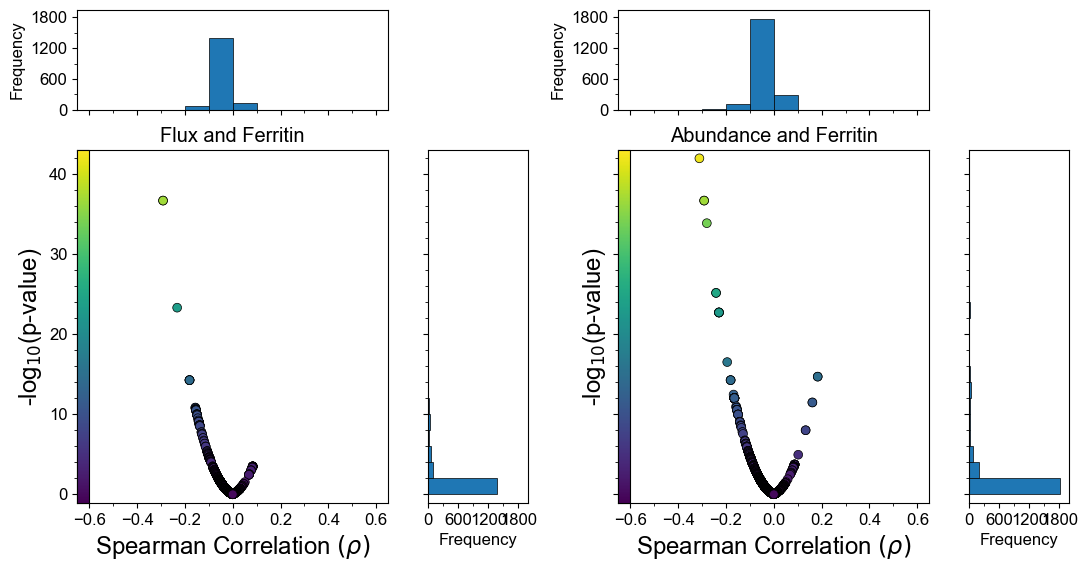

In [52]:
metadata_col = "Ferritin"
group_name = "ALL"  # Use models in visualizations
xmin, xmax = (-0.60, 0.60)
xpad = 0.05
plot_kwargs = dict(
    xmin=xmin,
    xmax=xmax,
    xpad=xpad,
    edgecolor=edgecolor,
    edgewidth=edgewidth,
    cmap=cmap,
    zorder=zorder,
    scatter_inch=scatter_inch,
    hist_inch=hist_inch,
    hist_pad=hist_pad,
    grid=grid,
    xtick_major=0.2,
    xtick_minor=0.1,  # Determines minor tick and thus bin size if not otherwise set
    # xbinwidth=0.1, # Determined by minor ticks if not otherwise set
    histx_ytick_major=600,  # Major y-tick interval for histogram aligned with x-axis
    ytick_major=10,
    ytick_minor=2,  # Determines minor tick and thus bin size if not otherwise set
    # ybinwidth=10,  # Determined by minor ticks if not otherwise set
    histy_xtick_major=600,  # Major x-tick interval for histogram aligned with y-axis
)
sharey = True


nrows, ncols = (1, 2)
fig, (ax_flux, ax_abun) = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(
        (scatter_inch + (hist_inch + hist_pad if histx else 0)) * ncols,
        (scatter_inch + (hist_inch + hist_pad if histy else 0)) * nrows,
    ),
    sharex=True,
    sharey=sharey,
)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Flux", metadata_col))].droplevel(1).copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_flux = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


df_corr = (
    df_all_correlations.loc[:, " and ".join(("Abundance", metadata_col))]
    .droplevel(1)
    .copy()
)
# Remove correlations that could not be calculated due to fixed/blocked flux
df_corr = df_corr[~df_corr.isna().any(axis=1)]
df_corr_abun = prepare_correlation_df(df_corr, pvalue_tol=pvalue_tol)


if sharey:
    plot_kwargs["ymax"] = max(
        df_corr_flux["pvalue"].max(), df_corr_abun["pvalue"].max()
    )

axes_flux = plot_correlations(
    df_corr_flux,
    ax=ax_flux,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
axes_abun = plot_correlations(
    df_corr_abun,
    ax=ax_abun,
    histx=histx,
    histy=histy,
    colorbar=True,
    vertical_lines={},
    **plot_kwargs,
)
print(
    df_all_correlations.loc[
        df_corr_flux.head(display_top_nhits).index,
        [c for c in df_all_correlations.columns if c[0] == f"Flux and {metadata_col}"],
    ]
)
print()
print(
    df_all_correlations.loc[
        df_corr_abun.head(display_top_nhits).index,
        [
            c
            for c in df_all_correlations.columns
            if c[0] == f"Abundance and {metadata_col}"
        ],
    ]
)
axes_flux[0].set_title(
    f"Flux and {metadata_col}",
    fontsize="x-large",
    loc="center",
)
axes_abun[0].set_title(
    f"Abundance and {metadata_col}", fontsize="x-large", loc="center"
)

axes_flux[1].sharey(axes_abun[1])
axes_flux[2].sharex(axes_abun[2])
fig;